In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import scipy.stats
from discrete_methods import *
from continuous_methods import *
import multiprocessing

In [3]:
np.random.seed(921942)
ar_cdel=ARProcess2d([0.01,0.1],corr=0)
Nsim=100000
Ntest=10000
ar_dat=np.exp(ar_cdel.simulate(Nsim))
ar_test=np.exp(ar_cdel.simulate(Ntest))


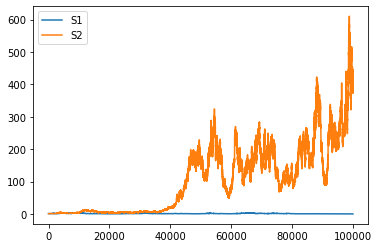

In [4]:
plt.plot(np.cumprod(ar_dat.iloc[0,:]))
plt.plot(np.cumprod(ar_dat.iloc[1,:]))
plt.legend(['S1','S2'])
plt.show()

In [5]:
true_qval_ar3=ar_cdel.discrete_true_qval(1e-8)

Time needed to converge with delta =  1e-08  :  544


In [6]:
class DQN2:
    def __init__(self, train_data, window=1, nb_asset=2, nb_action=11, gamma=0.98, batch_size=32, lr=0.1, units1=64,
                 units2=64, last_activation='relu', nb_epochs=1,adaptive_lr=False,tau=1):
        self.window = window
        self.lr = lr
        self.batch_size = batch_size
        self.last_activation = last_activation
        self.units1 = units1
        self.units2 = units2
        self.nb_epochs = nb_epochs
        self.nb_asset = train_data.shape[0]
        self.nb_action = nb_action
        self.model = self.build_model()
        self.model.summary()
        self.train_data = train_data
        self.gamma = gamma
        self.target_model = self.build_model()
        self.update_target_model()
        self.adaptive_lr=adaptive_lr
        self.tau = tau
        
        print('One state at the time')

    def build_model(self):
        inp = tf.keras.layers.Input(shape=(self.nb_asset * self.window,), name="Prev_ret")
        lay = tf.keras.layers.Dense(units=self.units1, activation='relu', name='Dense_1')(inp)
        lay = tf.keras.layers.Dense(units=self.units2, activation='relu', name='Dense_2')(lay)
        q_val = tf.keras.layers.Dense(units=self.nb_action, activation=self.last_activation, name='linear',
                                      kernel_initializer=keras.initializers.Ones(),
                                      bias_initializer=keras.initializers.Zeros())(lay)

        optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr)

        model = tf.keras.models.Model(inp, q_val)
        model.compile(loss='mse', optimizer=optimizer)
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def chooseW(self, state):
        q_val = self.model.predict(state,verbose=0)[0]
        print(q_val)
        w = np.argmax(q_val) / (self.nb_action - 1)
        return w

    def train(self):

        if self.window == 2:
            nb_episode = int(np.floor(self.train_data.shape[1]) / (1 + self.batch_size))
        else:
            nb_episode = int(np.floor(self.train_data.shape[1]) / self.batch_size)

        print('NB. episodes : ', nb_episode)

        for e in range(nb_episode - 1):
            if self.window == 2:
                update_input = self.get_state(np.array(
                    self.train_data.iloc[:, e * (1 + self.batch_size):(e + 1) * (1 + self.batch_size)])).transpose()
                update_nextstate = self.get_state(np.array(self.train_data.iloc[:,
                                                           e * (1 + self.batch_size) + 1:(e + 1) * (
                                                                       1 + self.batch_size) + 1])).transpose()
            else:
                update_input = self.get_state(
                    np.array(self.train_data.iloc[:, e * self.batch_size:(e + 1) * self.batch_size])).transpose()
                update_nextstate = self.get_state(np.array(
                    self.train_data.iloc[:, e * self.batch_size + 1:(e + 1) * self.batch_size + 1])).transpose()

            # q_val = self.model.predict(update_input)

            q_val_next = self.target_model.predict(update_nextstate,verbose=0)
            # q_val_next = self.model.predict(update_nextstate,verbose=0)
            q_val = np.zeros((self.batch_size, self.nb_action))
            for i in range(self.batch_size):
                for a in range(self.nb_action):
                    rew_temp = np.dot(np.array([[a / (self.nb_action - 1)], [1 - a / (self.nb_action - 1)]]).transpose(),
                           update_nextstate[i, (self.window - 1) * self.nb_asset:])[0]
                    q_val[i, a] = np.log(rew_temp) + self.gamma * np.max(q_val_next[i, :])
                    
                self.model.fit(update_input[i,:], q_val[i,:], verbose=0)


            if self.adaptive_lr:
                keras.backend.set_value(self.model.optimizer.learning_rate, self.lr/(1+e)**self.tau)

            self.update_target_model()

    def exploit(self, test_data, test=True, init_inv=100):
        w = np.zeros((2, test_data.shape[1] - self.window))
        w[0, :] = np.argmax(self.model.predict(self.get_state(np.array(test_data.iloc[:, :-1])).transpose(),verbose=0),
                            axis=1) / (self.nb_action - 1)
        w[1, :] = 1 - w[0, :]

        # ret = np.sum(w * test_data.iloc[:, 1:])
        # plt.plot(np.cumprod(ret))
        # plt.plot(np.cumprod(test_data.iloc[0,:]))
        # plt.plot(np.cumprod(test_data.iloc[1,:]))
        # plt.legend(['Trained policy','S1','S2'])
        # plt.show()

        return w

    def compare_DQN2_discrete(self, true_qval, plot = True,print_wrong_action=False):
        states = np.zeros((self.nb_asset * self.window, len(true_qval.keys())))
        for i in range(len(true_qval.keys())):
            states[:, i] = np.array(json.loads(list(true_qval.keys())[i]))

        if self.window == 2:
            temp = copy.deepcopy(states)
            states[1, :] = temp[2, :]
            states[2, :] = temp[1, :]

        pred = self.model.predict(states.transpose(),verbose=0)

        estimated_qval = dict()
        for i in range(len(true_qval.keys())):
            estimated_qval[list(true_qval.keys())[i]] = pred[i, :]

        no_wrong_action= True
        string_param=' Parameters are : lr = '+str(self.lr) + ', window = '+str(self.window)+', batch size = '+ str(self.batch_size)+', nb. epochs = '+str(self.nb_epochs)
        if self.units1 !=64:
            string_param += ', units1 = '+str(self.units1)
        if self.units2 !=64:
            string_param += ', units1 = '+str(self.units2)

        if self.last_activation!='relu':
            string_param += ', last activ. = '+self.last_activation

        if plot:
            print(string_param,flush=True)
            print('\n','Wrong actions : ',flush=True)
            nb_wrong_action=0
            for k in true_qval.keys():
                if np.argmax(true_qval[k]) != np.argmax(estimated_qval[k]):
                    nb_wrong_action+=1

            if nb_wrong_action ==0:
                print('Optimal policy derived !!', flush=True)
            elif nb_wrong_action <=10:
                for k in true_qval.keys():
                    if np.argmax(true_qval[k]) != np.argmax(estimated_qval[k]):
                        print(k, '; Action from discrete policy : ', np.argmax(true_qval[k]), '; Action from DQN2 algorithm : ',np.argmax(estimated_qval[k]),flush=True)
            elif print_wrong_action:
                for k in true_qval.keys():
                    if np.argmax(true_qval[k]) != np.argmax(estimated_qval[k]):
                        print(k, '; Action from discrete policy : ', np.argmax(true_qval[k]),
                              '; Action from DQN2 algorithm : ', np.argmax(estimated_qval[k]), flush=True)

        # print(estimated_qval)

        return [conv_qtables(true_qval, estimated_qval),estimated_qval, string_param]

    def get_state(self, data):
        state = copy.deepcopy(data)

        if self.window == 2:
            state = np.vstack((state[:, :-1], state[:, 1:]))

        return state



In [7]:
PROCESSES = 6
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for lr in [0.01,0.001,0.0001]:
        for batch_size in [32,256]:
                params.extend([create_param_DQN(pd.DataFrame(ar_dat),np.array(ar_test), window=1,lr=lr,batch_size=batch_size,nb_epochs=100,true_qval=true_qval_ar3)])
    
    jobs_ar3 = pool.map(multi_train, params)



 

 Parameters are : lr = 0.01, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


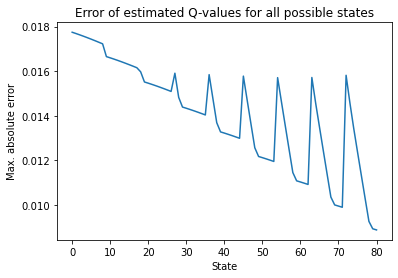


 

 Parameters are : lr = 0.01, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


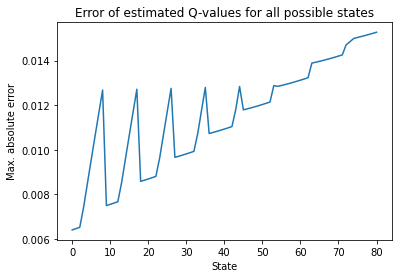


 

 Parameters are : lr = 0.001, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


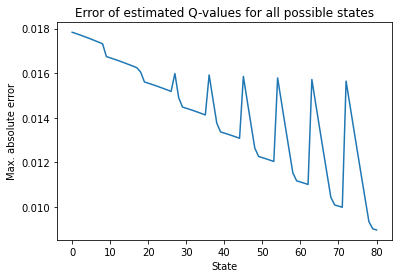


 

 Parameters are : lr = 0.001, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


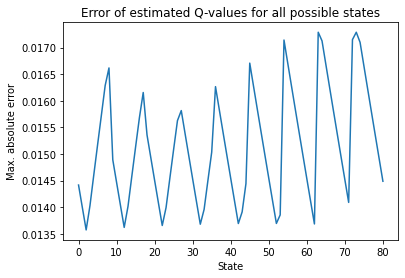


 

 Parameters are : lr = 0.0001, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  27


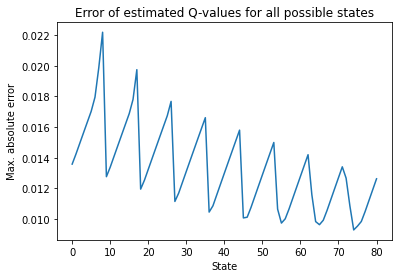


 

 Parameters are : lr = 0.0001, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


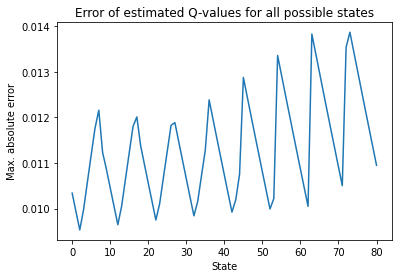

In [8]:
for j in jobs_ar3:
    plot_res_from_multi(j,true_qval_ar3)

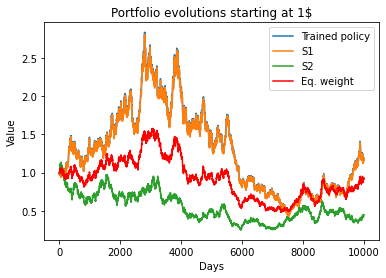

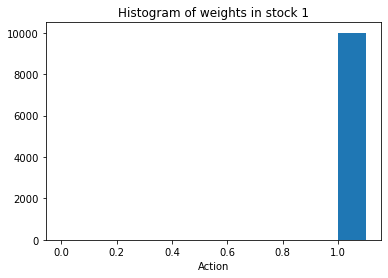

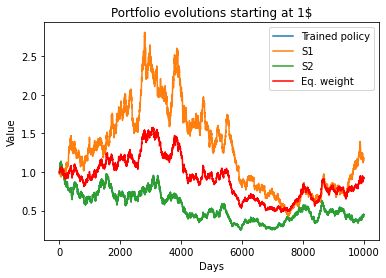

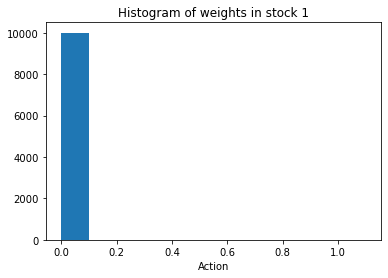

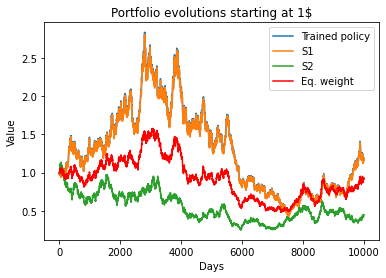

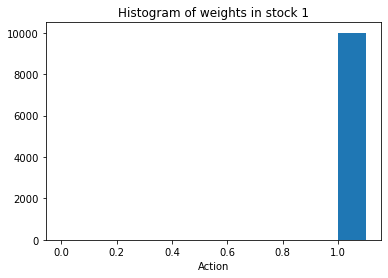

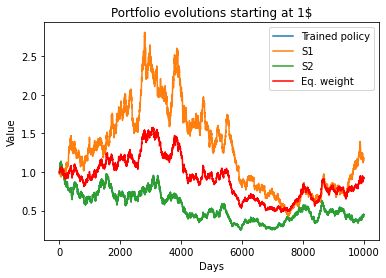

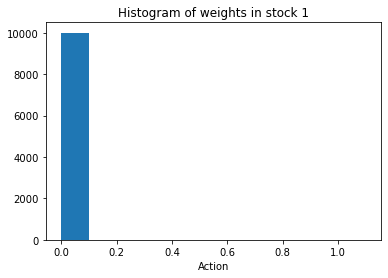

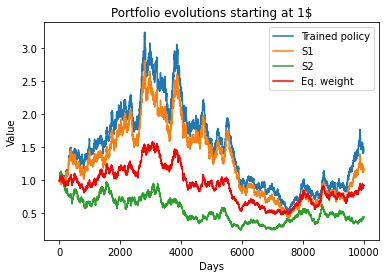

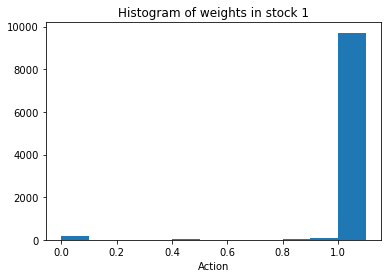

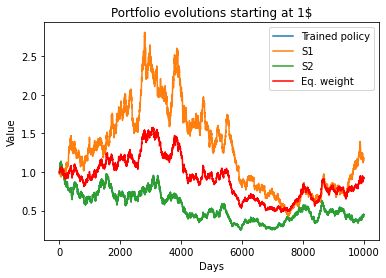

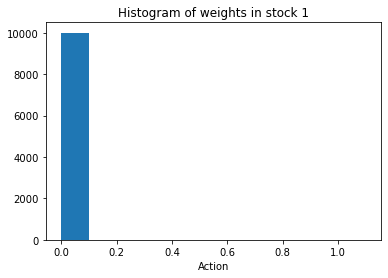

In [9]:
for x in jobs_ar3:
    plot_result(x['exploit_test'])

In [10]:
PROCESSES = 6
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for lr in [1,0.1,0.01]:
        for batch_size in [32,256]:
            params.extend([create_param_DQN(pd.DataFrame(ar_dat),np.array(ar_test), window=1,lr=lr,batch_size=batch_size,nb_epochs=100,true_qval=true_qval_ar3,adaptive_lr=True)])
    
    jobs_ar3_adaptlr = pool.map(multi_train, params)



 

 Parameters are : lr = 1, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


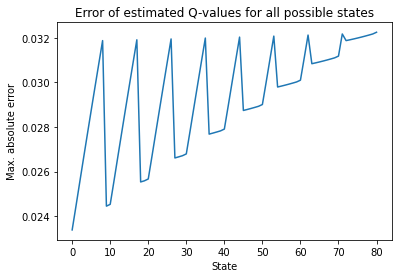


 

 Parameters are : lr = 1, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


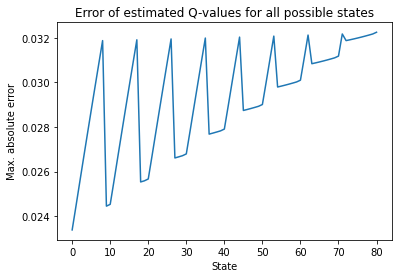


 

 Parameters are : lr = 0.1, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


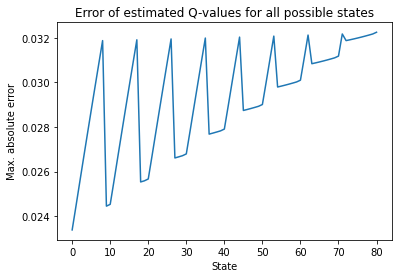


 

 Parameters are : lr = 0.1, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


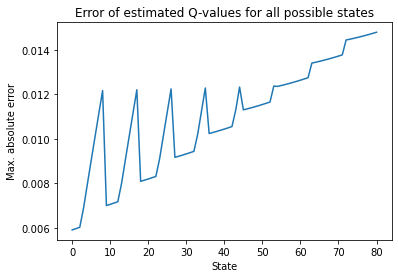


 

 Parameters are : lr = 0.01, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


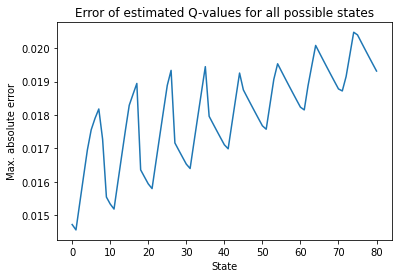


 

 Parameters are : lr = 0.01, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


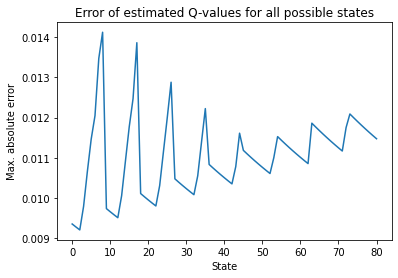

In [11]:
for j in jobs_ar3_adaptlr:
    plot_res_from_multi(j,true_qval_ar3)

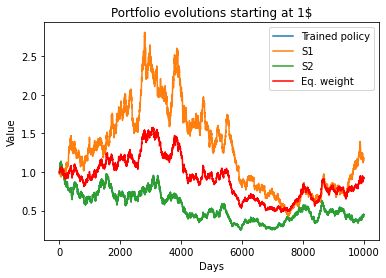

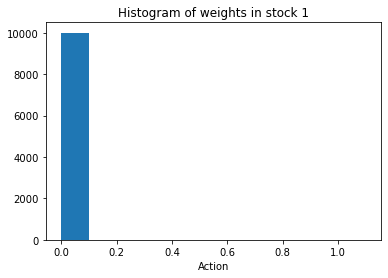

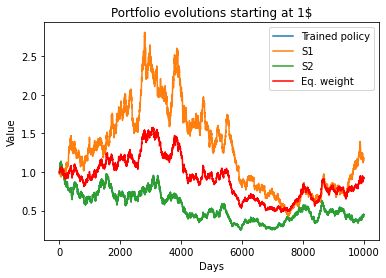

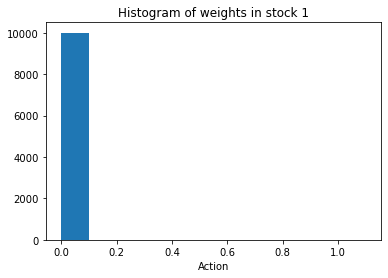

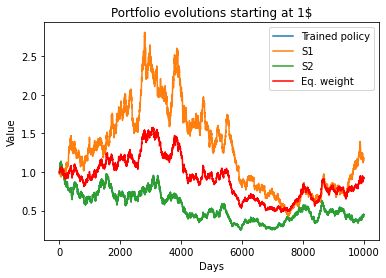

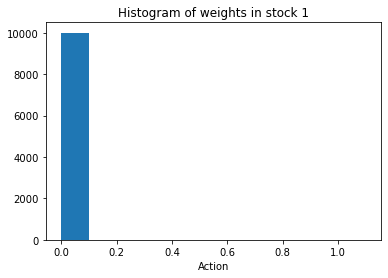

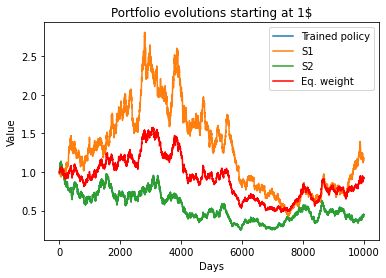

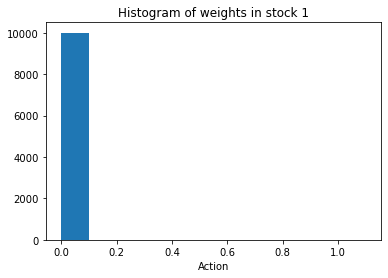

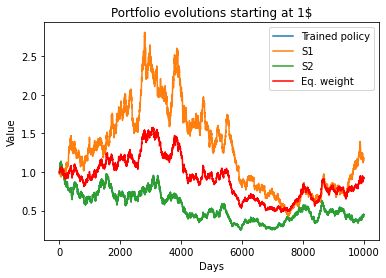

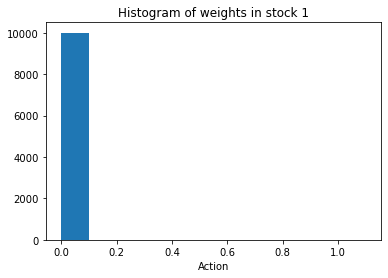

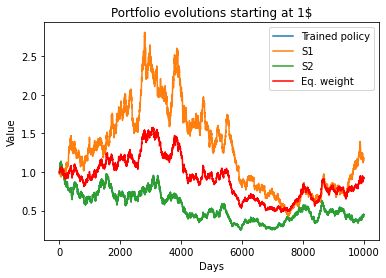

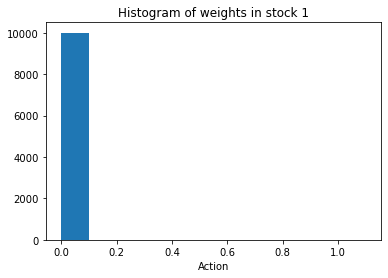

In [12]:
for x in jobs_ar3_adaptlr:
    plot_result(x['exploit_test'])

In [13]:
PROCESSES = 6
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for lr in [0.001,0.0001]:
        for batch_size in [32,54,256]:
            params.extend([create_param_DQN(pd.DataFrame(ar_dat),np.array(ar_test), window=1,lr=lr,batch_size=batch_size,nb_epochs=100,true_qval=true_qval_ar3,adaptive_lr=True)])
    
    jobs_ar3_adaptlr_smaller = pool.map(multi_train, params)



 

 Parameters are : lr = 0.001, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


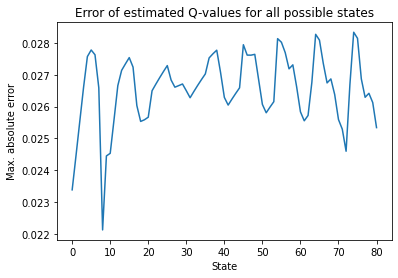


 

 Parameters are : lr = 0.001, window = 1, batch size = 54, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


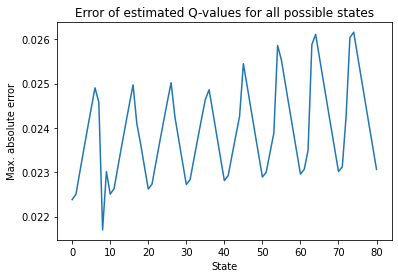


 

 Parameters are : lr = 0.001, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


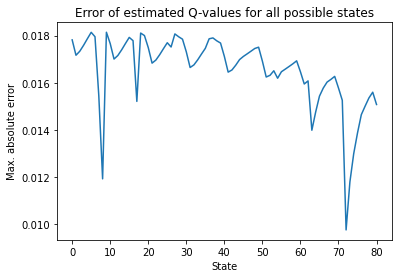


 

 Parameters are : lr = 0.0001, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


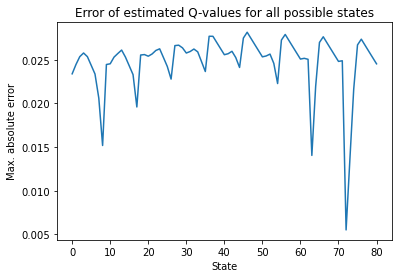


 

 Parameters are : lr = 0.0001, window = 1, batch size = 54, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


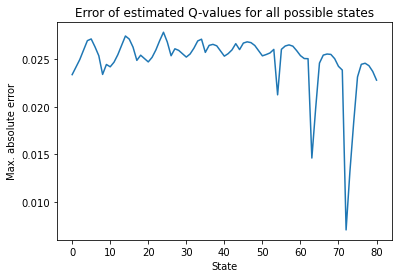


 

 Parameters are : lr = 0.0001, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


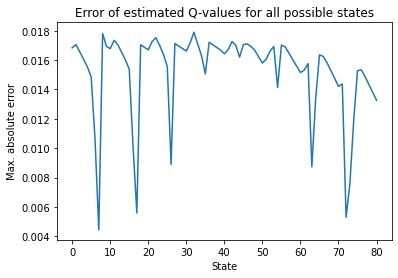

In [14]:
for j in jobs_ar3_adaptlr_smaller:
    plot_res_from_multi(j,true_qval_ar3)

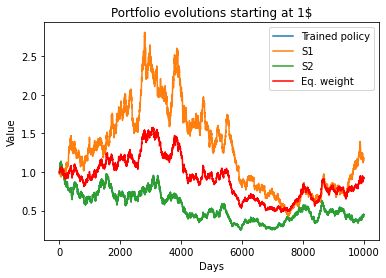

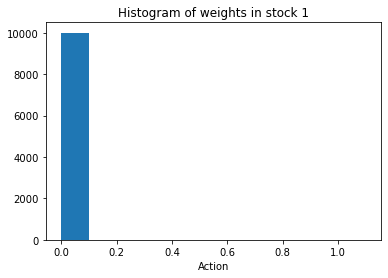

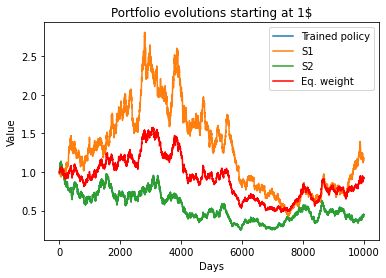

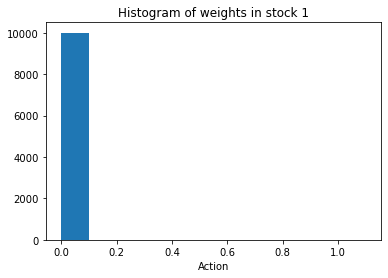

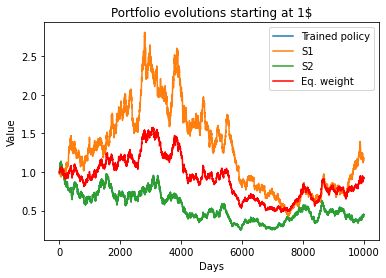

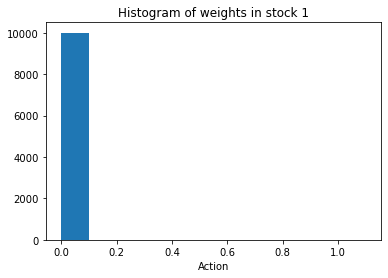

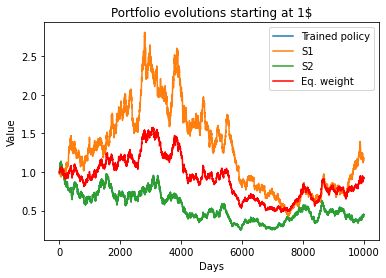

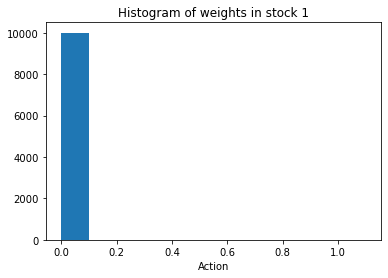

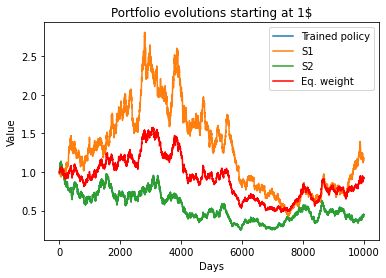

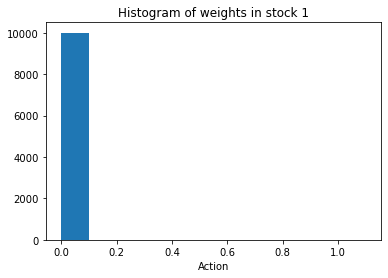

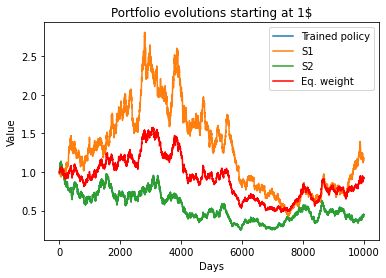

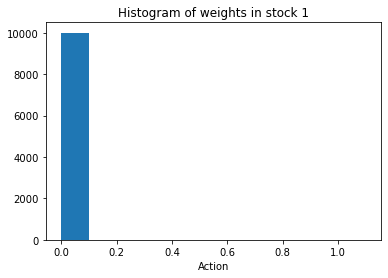

In [15]:
for x in jobs_ar3_adaptlr_smaller:
    plot_result(x['exploit_test'])

In [16]:
PROCESSES = 6
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for lr in [0.00001,0.000001]:
        for batch_size in [64,128,256]:
                params.extend([create_param_DQN(pd.DataFrame(ar_dat),np.array(ar_test), window=1,lr=lr,batch_size=batch_size,nb_epochs=100,true_qval=true_qval_ar3)])
    
    jobs_ar3_smaller = pool.map(multi_train, params)



 

 Parameters are : lr = 1e-05, window = 1, batch size = 64, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  81


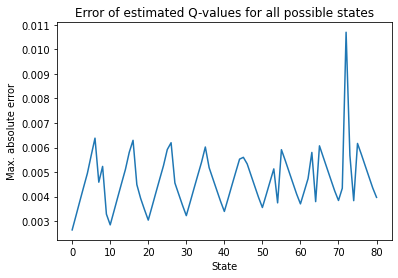


 

 Parameters are : lr = 1e-05, window = 1, batch size = 128, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  81


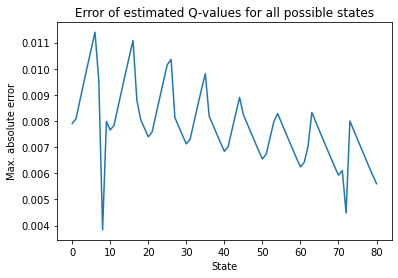


 

 Parameters are : lr = 1e-05, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


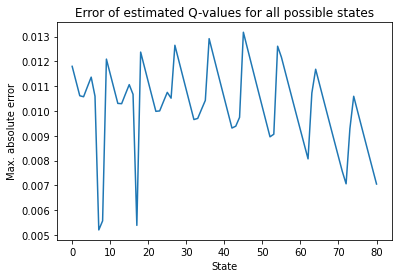


 

 Parameters are : lr = 1e-06, window = 1, batch size = 64, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


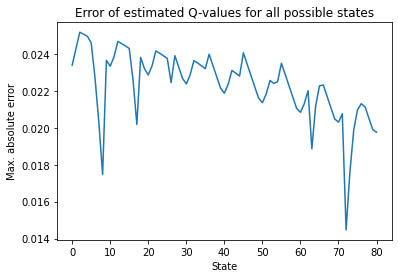


 

 Parameters are : lr = 1e-06, window = 1, batch size = 128, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


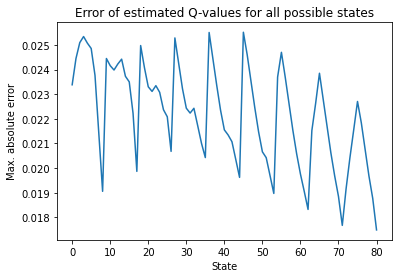


 

 Parameters are : lr = 1e-06, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


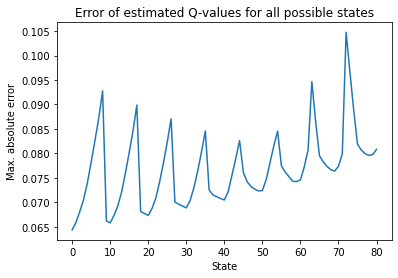

In [17]:
for j in jobs_ar3_smaller:
    plot_res_from_multi(j,true_qval_ar3)

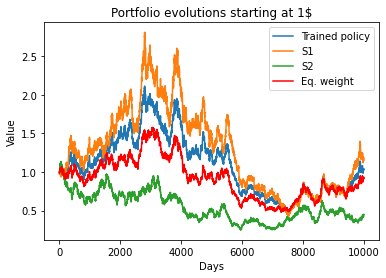

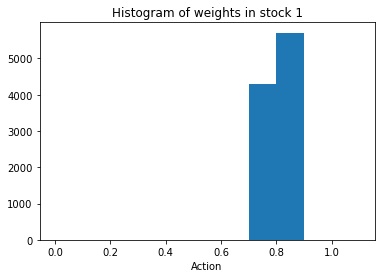

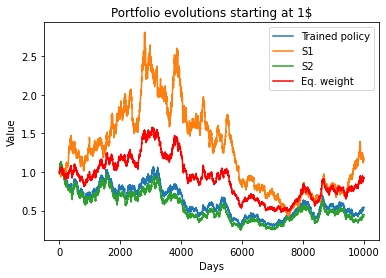

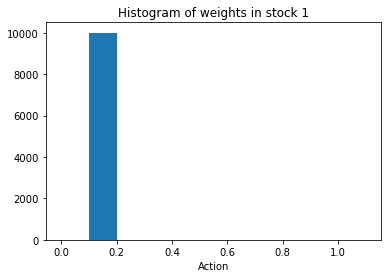

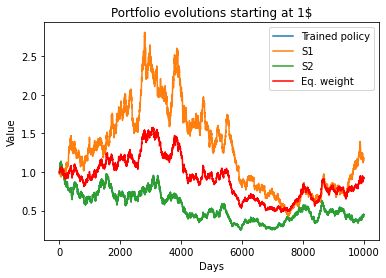

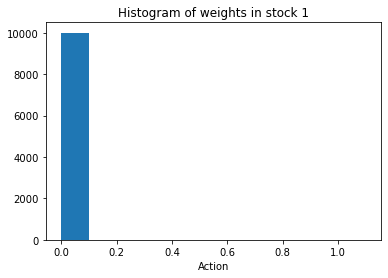

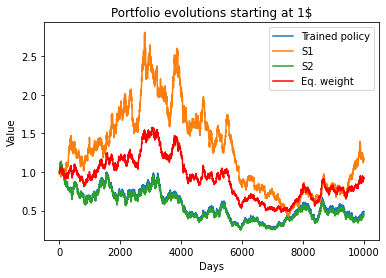

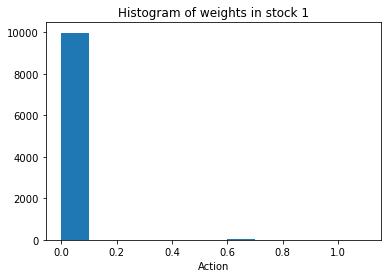

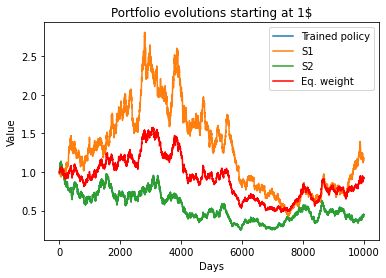

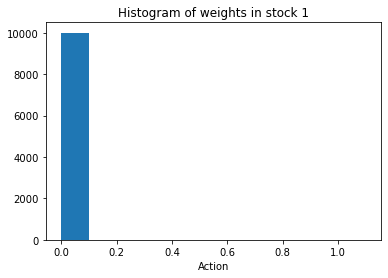

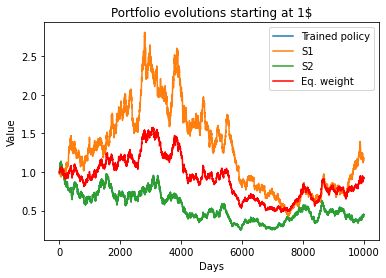

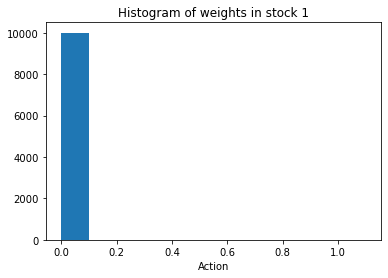

In [18]:
for x in jobs_ar3_smaller:
    plot_result(x['exploit_test'])

In [19]:
PROCESSES = 6
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for lr in [0.01,0.001,0.0001]:
        for batch_size in [32,256]:
                params.extend([create_param_DQN(pd.DataFrame(ar_dat),np.array(ar_test), window=2,lr=lr,batch_size=batch_size,nb_epochs=100,true_qval=true_qval_ar3)])
    
    jobs_ar3_w2 = pool.map(multi_train, params)



 

 Parameters are : lr = 0.01, window = 2, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  3645


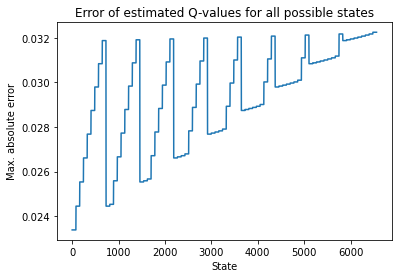


 

 Parameters are : lr = 0.01, window = 2, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  3645


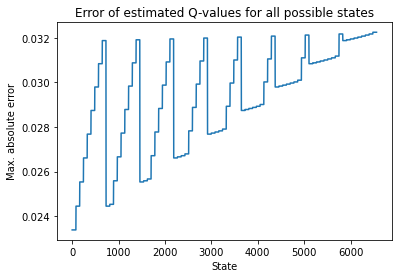


 

 Parameters are : lr = 0.001, window = 2, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  3645


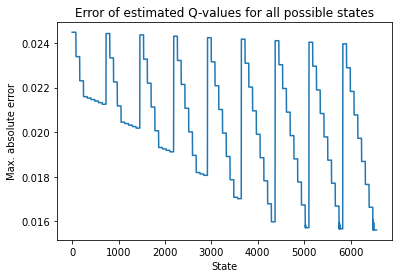


 

 Parameters are : lr = 0.001, window = 2, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  3548


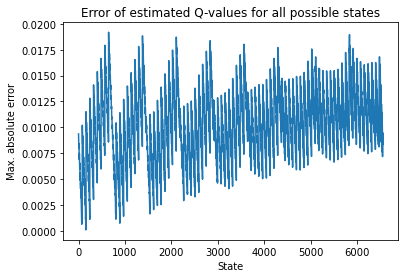


 

 Parameters are : lr = 0.0001, window = 2, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  3530


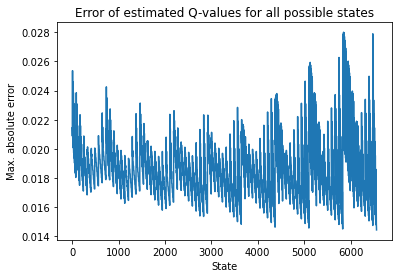


 

 Parameters are : lr = 0.0001, window = 2, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  3645


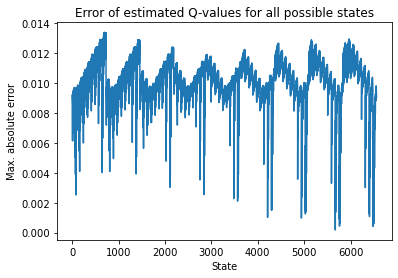

In [20]:
for j in jobs_ar3_w2:
    plot_res_from_multi(j,true_qval_ar3)

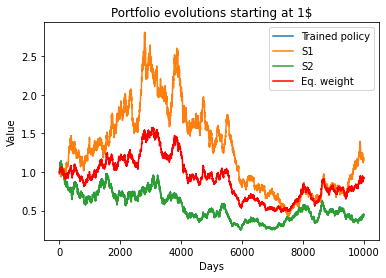

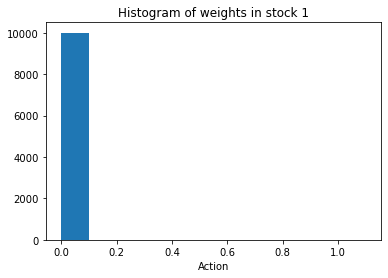

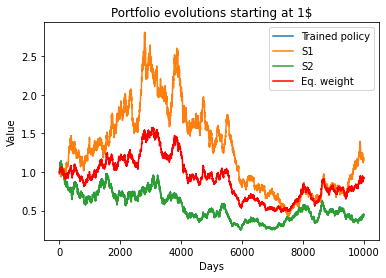

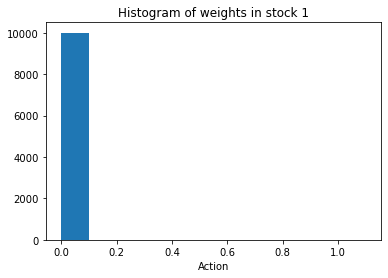

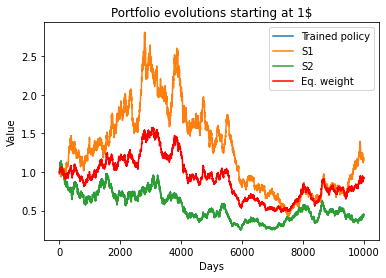

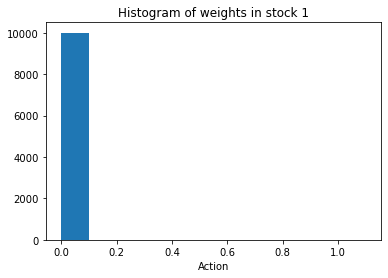

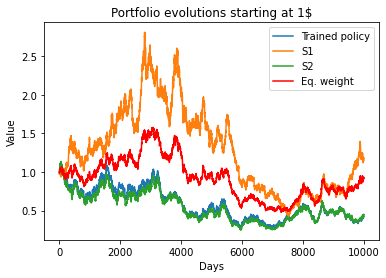

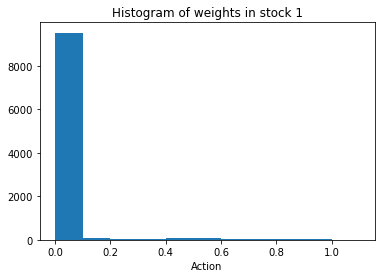

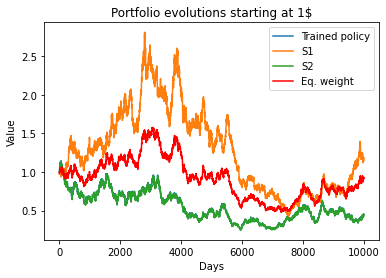

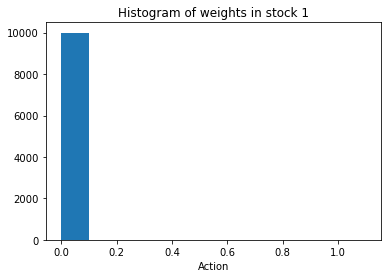

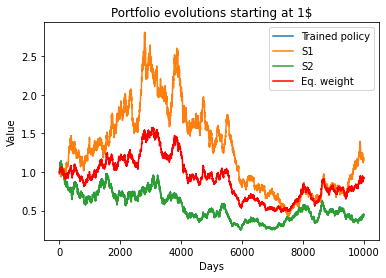

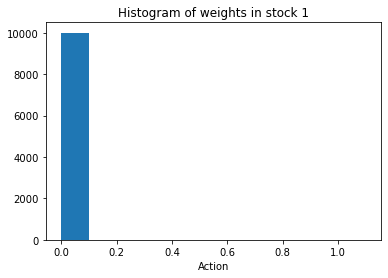

In [21]:
for x in jobs_ar3_w2:
    plot_result(x['exploit_test'])

In [22]:
PROCESSES = 6
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for lr in [1,0.1,0.01]:
        for batch_size in [32,256]:
            params.extend([create_param_DQN(pd.DataFrame(ar_dat),np.array(ar_test), window=2,lr=lr,batch_size=batch_size,nb_epochs=100,true_qval=true_qval_ar3,adaptive_lr=True)])
    
    jobs_ar3_adaptlr_w2 = pool.map(multi_train, params)



 

 Parameters are : lr = 1, window = 2, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  3645


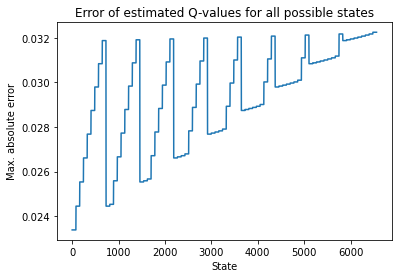


 

 Parameters are : lr = 1, window = 2, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  3645


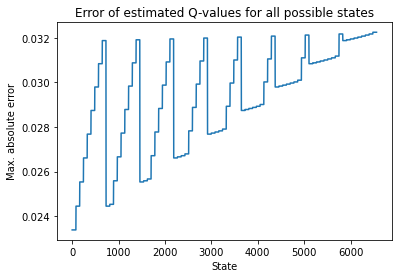


 

 Parameters are : lr = 0.1, window = 2, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  3645


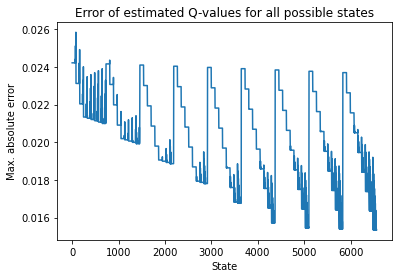


 

 Parameters are : lr = 0.1, window = 2, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  3645


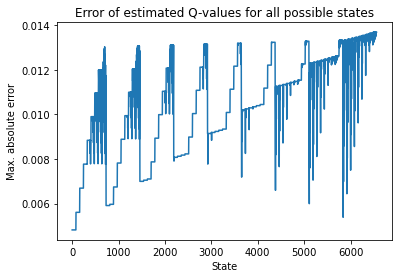


 

 Parameters are : lr = 0.01, window = 2, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  3636


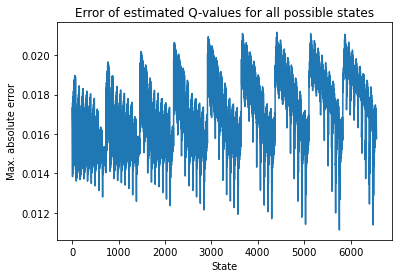


 

 Parameters are : lr = 0.01, window = 2, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  2956


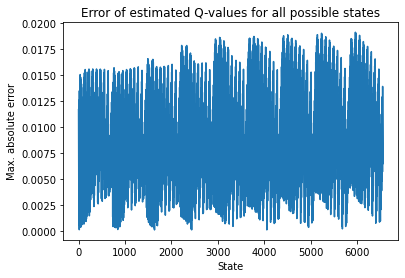

In [23]:
for j in jobs_ar3_adaptlr_w2:
    plot_res_from_multi(j,true_qval_ar3)

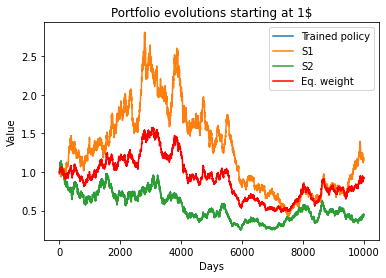

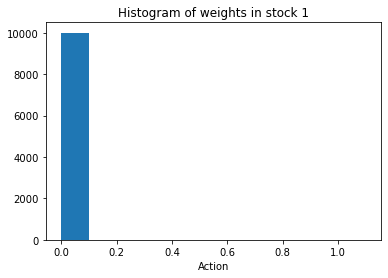

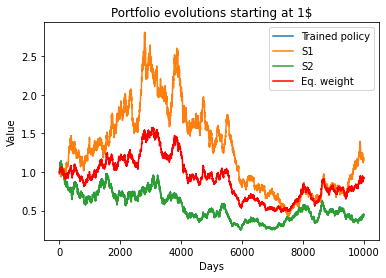

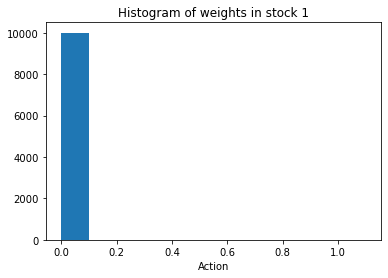

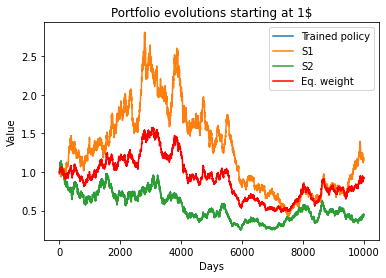

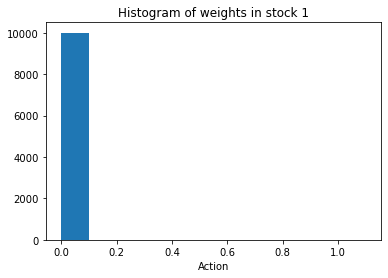

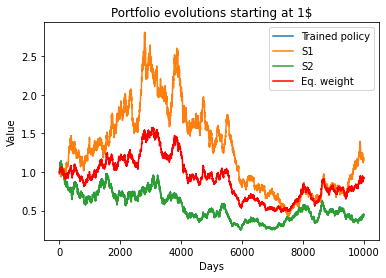

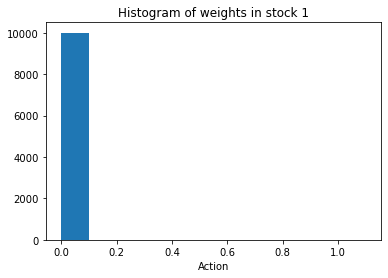

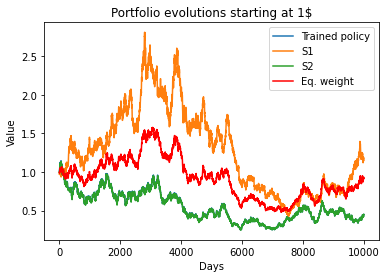

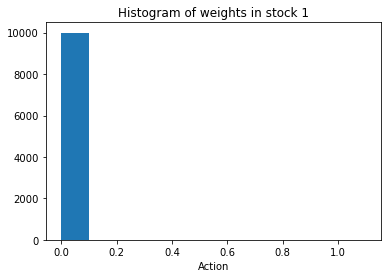

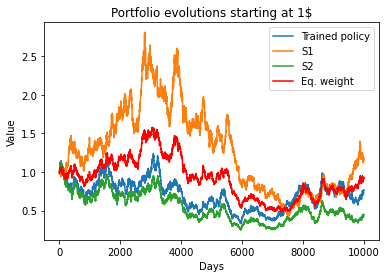

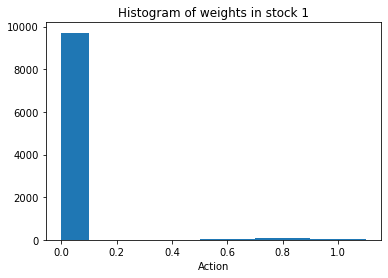

In [24]:
for x in jobs_ar3_adaptlr_w2:
    plot_result(x['exploit_test'])

In [25]:
class DQN2:
    def __init__(self, train_data, window=1, nb_asset=2, nb_action=11, gamma=0.98, batch_size=32, lr=0.1, units1=64,
                 units2=64, last_activation='relu', nb_epochs=1,adaptive_lr=False,tau=1):
        self.window = window
        self.lr = lr
        self.batch_size = batch_size
        self.last_activation = last_activation
        self.units1 = units1
        self.units2 = units2
        self.nb_epochs = nb_epochs
        self.nb_asset = train_data.shape[0]
        self.nb_action = nb_action
        self.model = self.build_model()
        self.model.summary()
        self.train_data = train_data
        self.gamma = gamma
        self.target_model = self.build_model()
        self.update_target_model()
        self.adaptive_lr=adaptive_lr
        self.tau = tau
        
        print('One state at the time')

    def build_model(self):
        inp = tf.keras.layers.Input(shape=(self.nb_asset * self.window,), name="Prev_ret")
        lay = tf.keras.layers.Dense(units=self.units1, activation='relu', name='Dense_1')(inp)
        lay = tf.keras.layers.Dense(units=self.units2, activation='relu', name='Dense_2')(lay)
        q_val = tf.keras.layers.Dense(units=self.nb_action, activation=self.last_activation, name='linear',
                                      kernel_initializer=keras.initializers.Ones(),
                                      bias_initializer=keras.initializers.Zeros())(lay)

        optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr)

        model = tf.keras.models.Model(inp, q_val)
        model.compile(loss='mse', optimizer=optimizer)
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def chooseW(self, state):
        q_val = self.model.predict(state,verbose=0)[0]
        print(q_val)
        w = np.argmax(q_val) / (self.nb_action - 1)
        return w

    def train(self):

        if self.window == 2:
            nb_episode = int(np.floor(self.train_data.shape[1]) / (1 + self.batch_size))
        else:
            nb_episode = int(np.floor(self.train_data.shape[1]) / self.batch_size)

        print('NB. episodes : ', nb_episode)

        for e in range(nb_episode - 1):
            if self.window == 2:
                update_input = self.get_state(np.array(
                    self.train_data.iloc[:, e * (1 + self.batch_size):(e + 1) * (1 + self.batch_size)])).transpose()
                update_nextstate = self.get_state(np.array(self.train_data.iloc[:,
                                                           e * (1 + self.batch_size) + 1:(e + 1) * (
                                                                       1 + self.batch_size) + 1])).transpose()
            else:
                update_input = self.get_state(
                    np.array(self.train_data.iloc[:, e * self.batch_size:(e + 1) * self.batch_size])).transpose()
                update_nextstate = self.get_state(np.array(
                    self.train_data.iloc[:, e * self.batch_size + 1:(e + 1) * self.batch_size + 1])).transpose()

            # q_val = self.model.predict(update_input)

            q_val_next = self.target_model.predict(update_nextstate,verbose=0)
            # q_val_next = self.model.predict(update_nextstate,verbose=0)
            q_val = np.zeros((self.batch_size, self.nb_action))
            for i in range(self.batch_size):
                for a in range(self.nb_action):
                    rew_temp = np.dot(np.array([[a / (self.nb_action - 1)], [1 - a / (self.nb_action - 1)]]).transpose(),
                           update_nextstate[i, (self.window - 1) * self.nb_asset:])[0]
                    q_val[i, a] = np.log(rew_temp) + self.gamma * np.max(q_val_next[i, :])
                    
                self.model.fit(update_input[i,:], q_val[i,:],epochs=30,verbose=0)


            if self.adaptive_lr:
                keras.backend.set_value(self.model.optimizer.learning_rate, self.lr/(1+e)**self.tau)

            self.update_target_model()

    def exploit(self, test_data, test=True, init_inv=100):
        w = np.zeros((2, test_data.shape[1] - self.window))
        w[0, :] = np.argmax(self.model.predict(self.get_state(np.array(test_data.iloc[:, :-1])).transpose(),verbose=0),
                            axis=1) / (self.nb_action - 1)
        w[1, :] = 1 - w[0, :]

        # ret = np.sum(w * test_data.iloc[:, 1:])
        # plt.plot(np.cumprod(ret))
        # plt.plot(np.cumprod(test_data.iloc[0,:]))
        # plt.plot(np.cumprod(test_data.iloc[1,:]))
        # plt.legend(['Trained policy','S1','S2'])
        # plt.show()

        return w

    def compare_DQN2_discrete(self, true_qval, plot = True,print_wrong_action=False):
        states = np.zeros((self.nb_asset * self.window, len(true_qval.keys())))
        for i in range(len(true_qval.keys())):
            states[:, i] = np.array(json.loads(list(true_qval.keys())[i]))

        if self.window == 2:
            temp = copy.deepcopy(states)
            states[1, :] = temp[2, :]
            states[2, :] = temp[1, :]

        pred = self.model.predict(states.transpose(),verbose=0)

        estimated_qval = dict()
        for i in range(len(true_qval.keys())):
            estimated_qval[list(true_qval.keys())[i]] = pred[i, :]

        no_wrong_action= True
        string_param=' Parameters are : lr = '+str(self.lr) + ', window = '+str(self.window)+', batch size = '+ str(self.batch_size)+', nb. epochs = '+str(self.nb_epochs)
        if self.units1 !=64:
            string_param += ', units1 = '+str(self.units1)
        if self.units2 !=64:
            string_param += ', units1 = '+str(self.units2)

        if self.last_activation!='relu':
            string_param += ', last activ. = '+self.last_activation

        if plot:
            print(string_param,flush=True)
            print('\n','Wrong actions : ',flush=True)
            nb_wrong_action=0
            for k in true_qval.keys():
                if np.argmax(true_qval[k]) != np.argmax(estimated_qval[k]):
                    nb_wrong_action+=1

            if nb_wrong_action ==0:
                print('Optimal policy derived !!', flush=True)
            elif nb_wrong_action <=10:
                for k in true_qval.keys():
                    if np.argmax(true_qval[k]) != np.argmax(estimated_qval[k]):
                        print(k, '; Action from discrete policy : ', np.argmax(true_qval[k]), '; Action from DQN2 algorithm : ',np.argmax(estimated_qval[k]),flush=True)
            elif print_wrong_action:
                for k in true_qval.keys():
                    if np.argmax(true_qval[k]) != np.argmax(estimated_qval[k]):
                        print(k, '; Action from discrete policy : ', np.argmax(true_qval[k]),
                              '; Action from DQN2 algorithm : ', np.argmax(estimated_qval[k]), flush=True)

        # print(estimated_qval)

        return [conv_qtables(true_qval, estimated_qval),estimated_qval, string_param]

    def get_state(self, data):
        state = copy.deepcopy(data)

        if self.window == 2:
            state = np.vstack((state[:, :-1], state[:, 1:]))

        return state



In [26]:
PROCESSES = 6
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for lr in [0.01,0.001,0.0001]:
        for batch_size in [32,256]:
                params.extend([create_param_DQN(pd.DataFrame(ar_dat),np.array(ar_test), window=1,lr=lr,batch_size=batch_size,nb_epochs=100,true_qval=true_qval_ar3)])
    
    jobs_ar3 = pool.map(multi_train, params)



 

 Parameters are : lr = 0.01, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


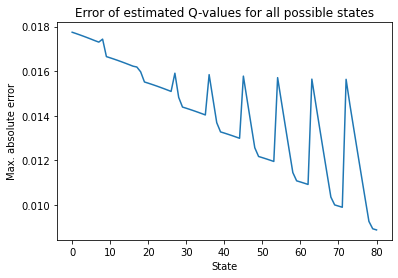


 

 Parameters are : lr = 0.01, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


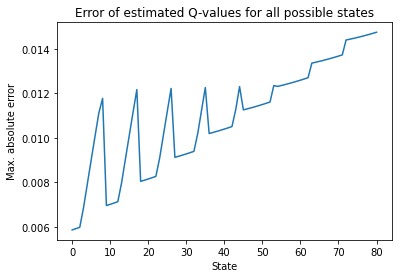


 

 Parameters are : lr = 0.001, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


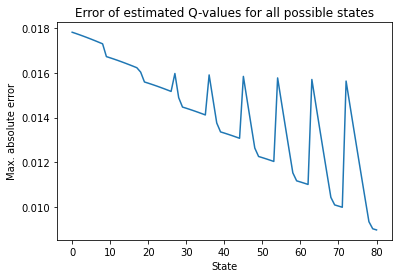


 

 Parameters are : lr = 0.001, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


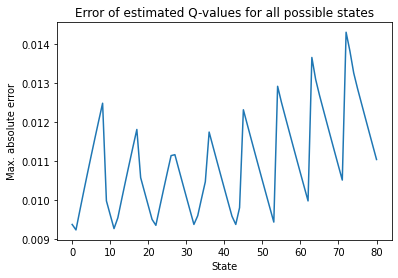


 

 Parameters are : lr = 0.0001, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  27


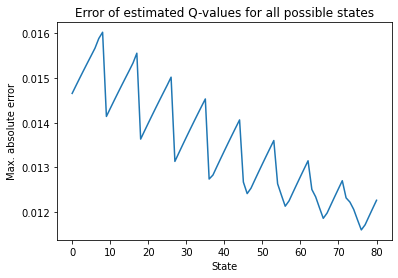


 

 Parameters are : lr = 0.0001, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


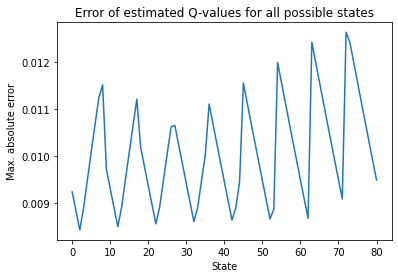

In [27]:
for j in jobs_ar3:
    plot_res_from_multi(j,true_qval_ar3)

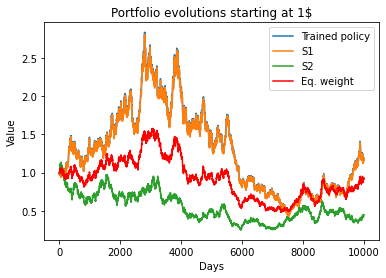

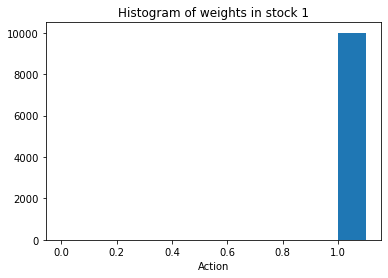

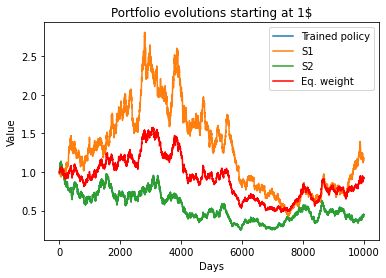

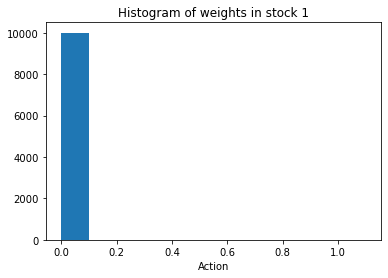

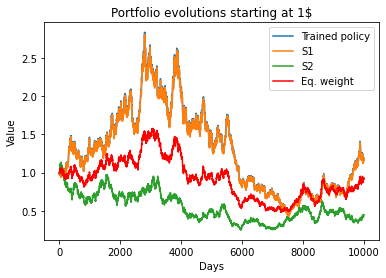

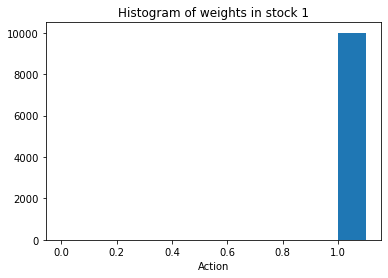

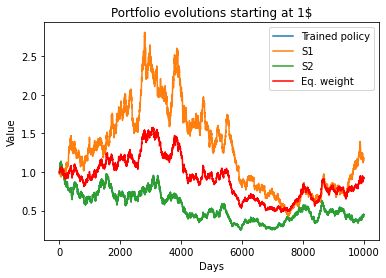

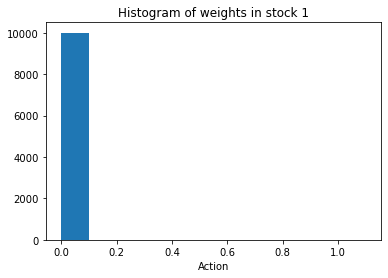

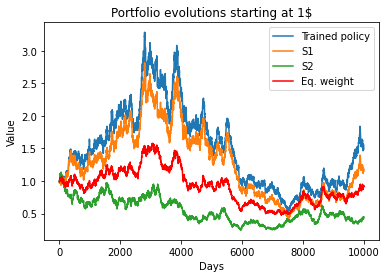

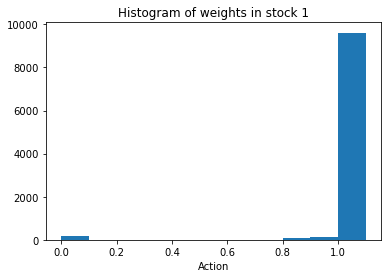

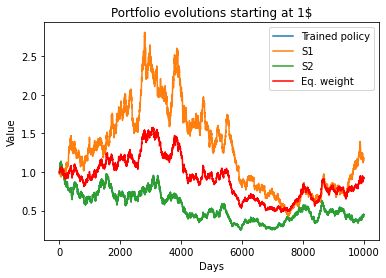

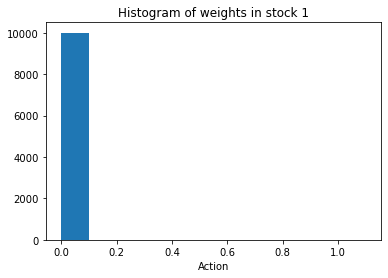

In [28]:
for x in jobs_ar3:
    plot_result(x['exploit_test'])

In [29]:
PROCESSES = 6
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for lr in [1,0.1,0.01]:
        for batch_size in [32,256]:
            params.extend([create_param_DQN(pd.DataFrame(ar_dat),np.array(ar_test), window=1,lr=lr,batch_size=batch_size,nb_epochs=100,true_qval=true_qval_ar3,adaptive_lr=True)])
    
    jobs_ar3_adaptlr = pool.map(multi_train, params)



 

 Parameters are : lr = 1, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


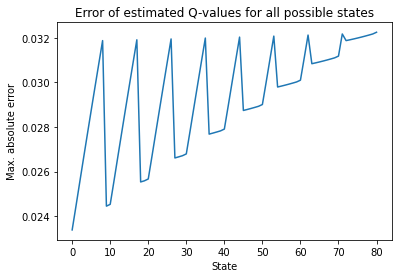


 

 Parameters are : lr = 1, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


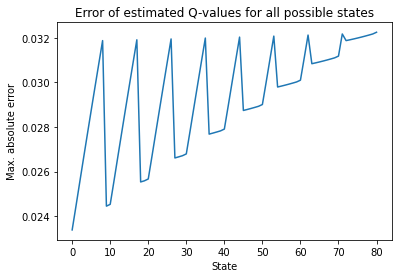


 

 Parameters are : lr = 0.1, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  25


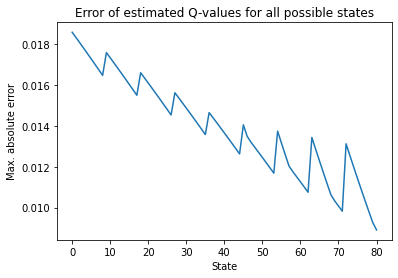


 

 Parameters are : lr = 0.1, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


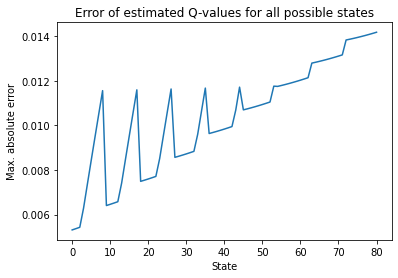


 

 Parameters are : lr = 0.01, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


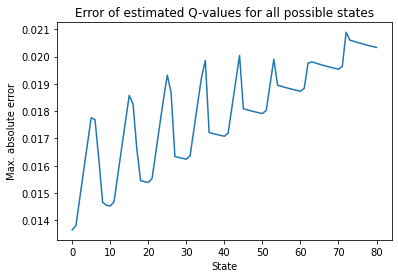


 

 Parameters are : lr = 0.01, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


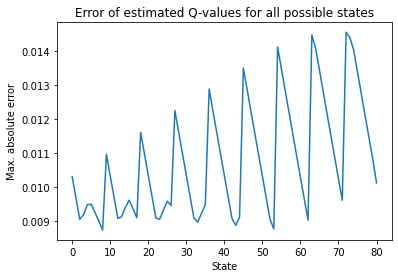

In [30]:
for j in jobs_ar3_adaptlr:
    plot_res_from_multi(j,true_qval_ar3)

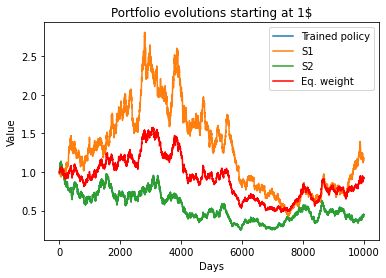

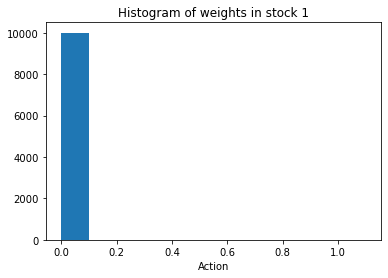

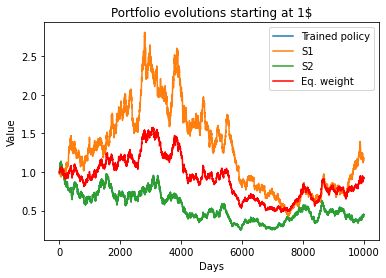

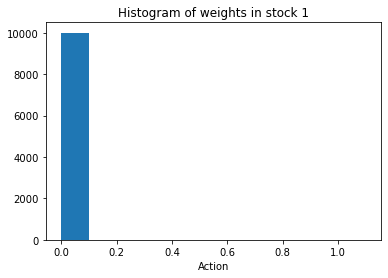

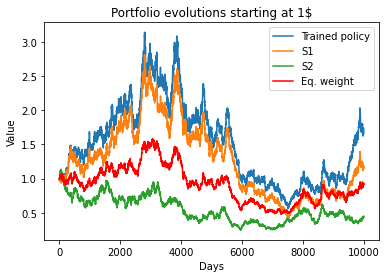

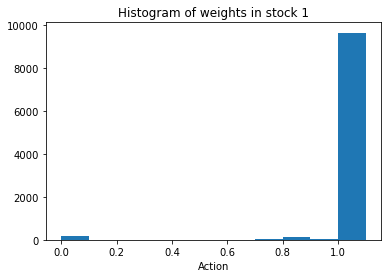

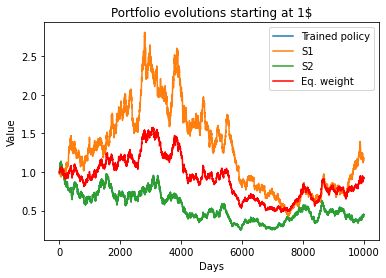

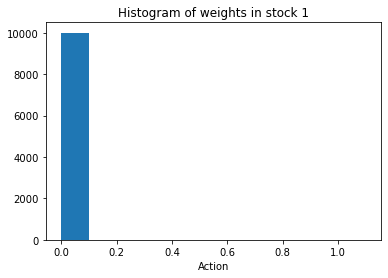

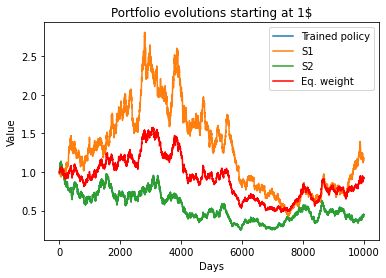

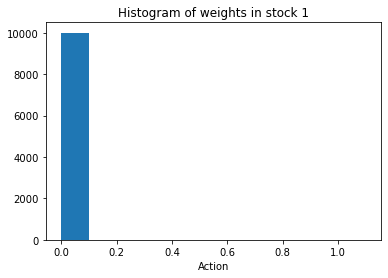

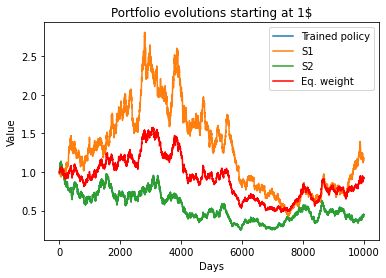

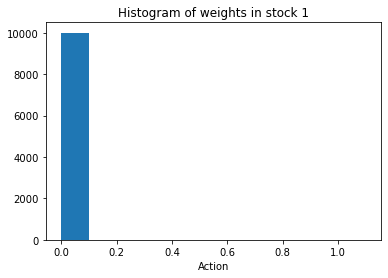

In [31]:
for x in jobs_ar3_adaptlr:
    plot_result(x['exploit_test'])

In [32]:
PROCESSES = 6
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for lr in [0.001,0.0001]:
        for batch_size in [32,54,256]:
            params.extend([create_param_DQN(pd.DataFrame(ar_dat),np.array(ar_test), window=1,lr=lr,batch_size=batch_size,nb_epochs=100,true_qval=true_qval_ar3,adaptive_lr=True)])
    
    jobs_ar3_adaptlr_smaller = pool.map(multi_train, params)



 

 Parameters are : lr = 0.001, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  35


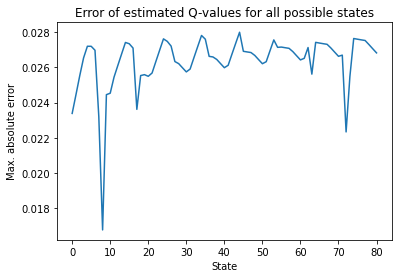


 

 Parameters are : lr = 0.001, window = 1, batch size = 54, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  35


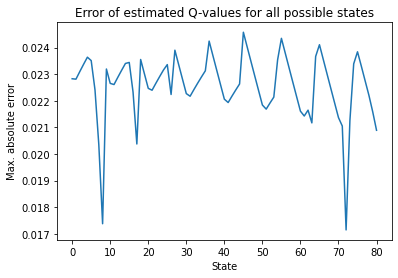


 

 Parameters are : lr = 0.001, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  42


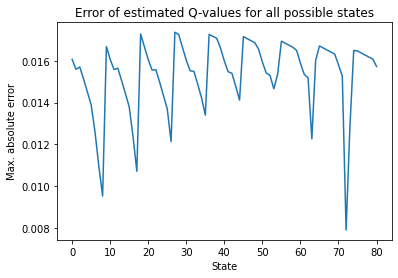


 

 Parameters are : lr = 0.0001, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


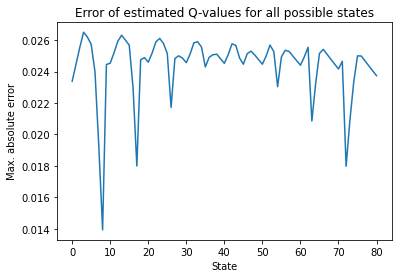


 

 Parameters are : lr = 0.0001, window = 1, batch size = 54, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


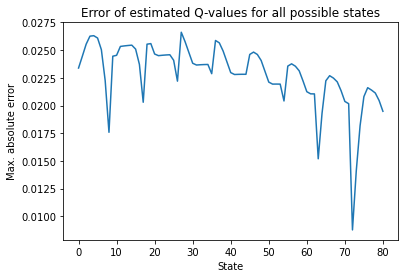


 

 Parameters are : lr = 0.0001, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


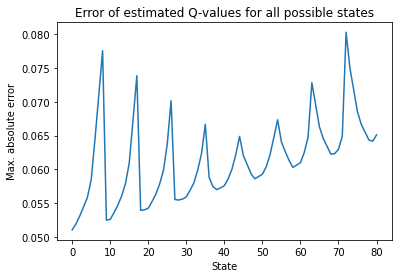

In [33]:
for j in jobs_ar3_adaptlr_smaller:
    plot_res_from_multi(j,true_qval_ar3)

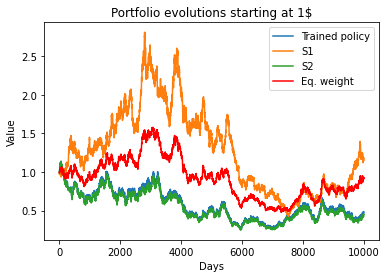

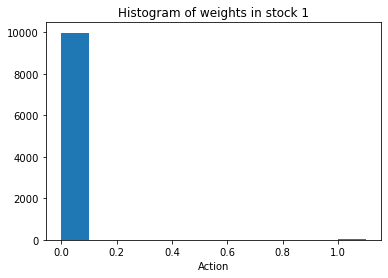

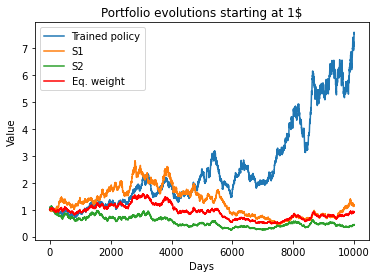

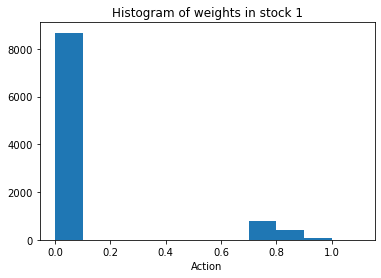

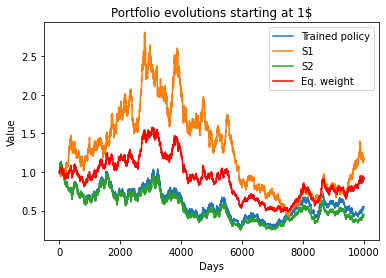

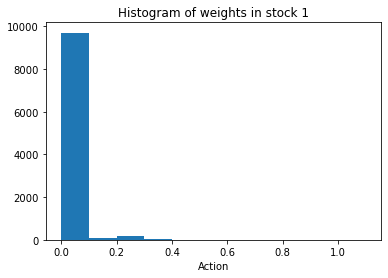

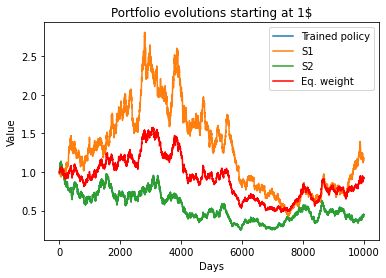

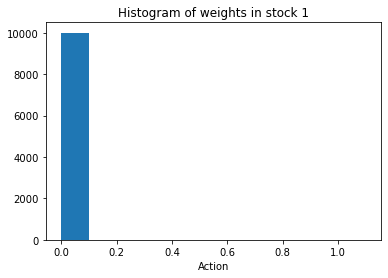

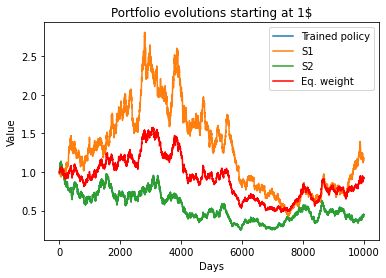

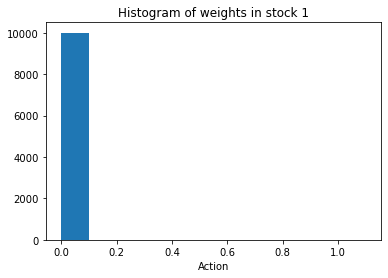

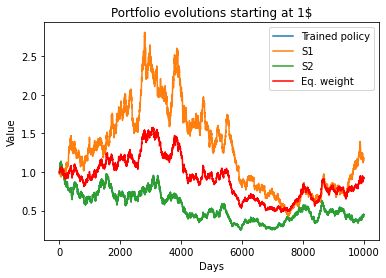

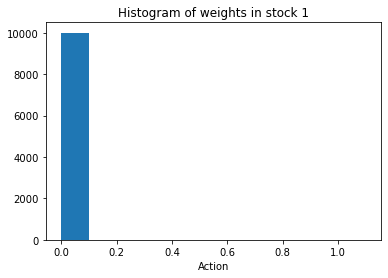

In [34]:
for x in jobs_ar3_adaptlr_smaller:
    plot_result(x['exploit_test'])

In [35]:
PROCESSES = 6
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for lr in [0.00001,0.000001]:
        for batch_size in [64,128,256]:
                params.extend([create_param_DQN(pd.DataFrame(ar_dat),np.array(ar_test), window=1,lr=lr,batch_size=batch_size,nb_epochs=100,true_qval=true_qval_ar3)])
    
    jobs_ar3_smaller = pool.map(multi_train, params)



 

 Parameters are : lr = 1e-05, window = 1, batch size = 64, nb. epochs = 100

 Wrong actions : 
[0.99, 0.99] ; Action from discrete policy :  5 ; Action from DQN2 algorithm :  6
[1.0, 1.0] ; Action from discrete policy :  5 ; Action from DQN2 algorithm :  8
[1.01, 1.01] ; Action from discrete policy :  5 ; Action from DQN2 algorithm :  9
[1.02, 1.02] ; Action from discrete policy :  5 ; Action from DQN2 algorithm :  9
[1.03, 1.03] ; Action from discrete policy :  5 ; Action from DQN2 algorithm :  10
[1.04, 1.04] ; Action from discrete policy :  5 ; Action from DQN2 algorithm :  0


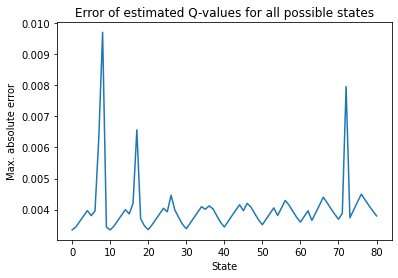


 

 Parameters are : lr = 1e-05, window = 1, batch size = 128, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  80


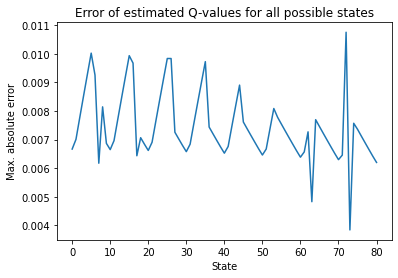


 

 Parameters are : lr = 1e-05, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


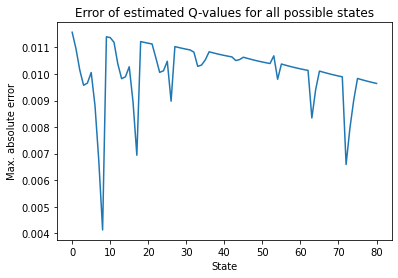


 

 Parameters are : lr = 1e-06, window = 1, batch size = 64, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


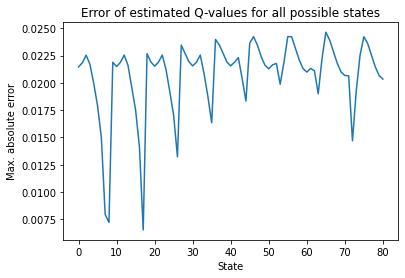


 

 Parameters are : lr = 1e-06, window = 1, batch size = 128, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


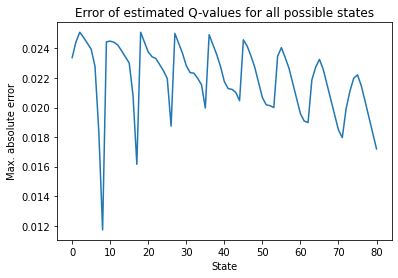


 

 Parameters are : lr = 1e-06, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


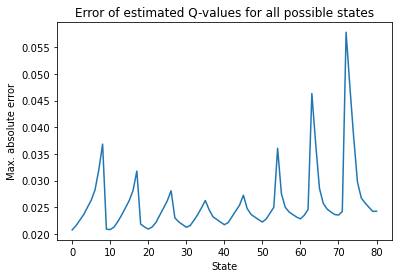

In [36]:
for j in jobs_ar3_smaller:
    plot_res_from_multi(j,true_qval_ar3)

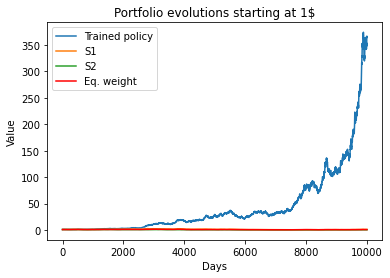

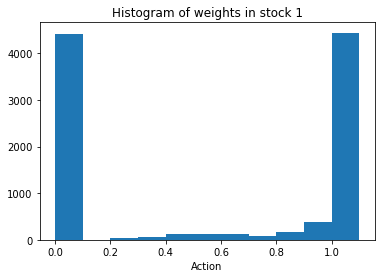

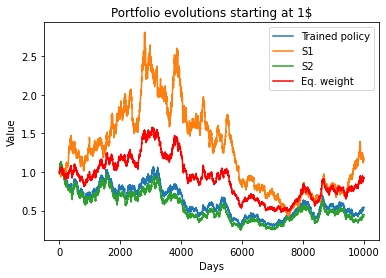

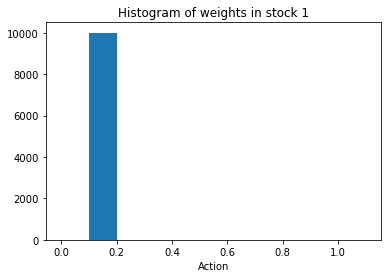

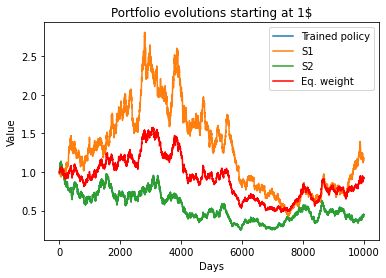

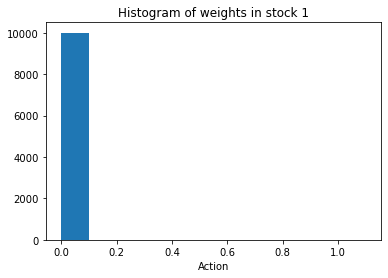

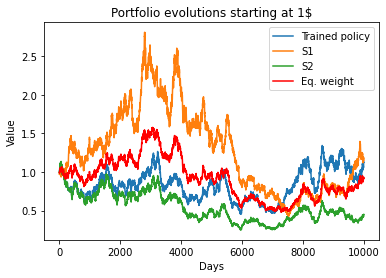

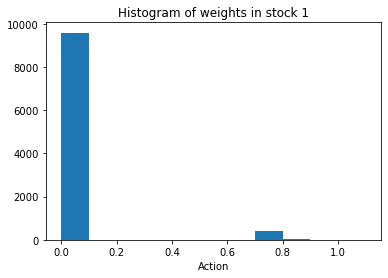

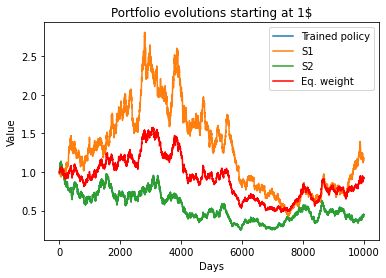

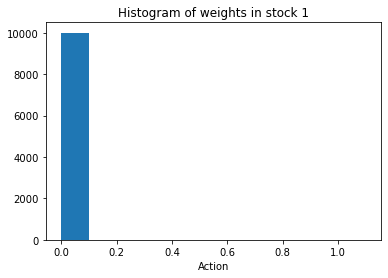

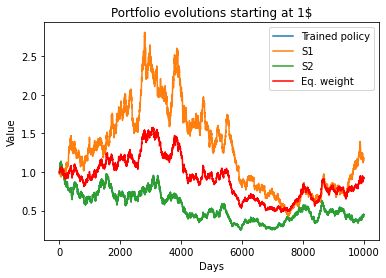

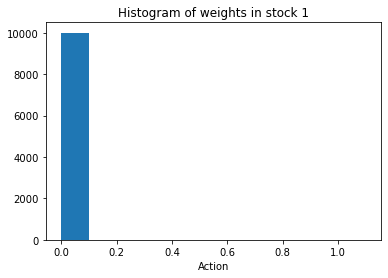

In [37]:
for x in jobs_ar3_smaller:
    plot_result(x['exploit_test'])

In [38]:
PROCESSES = 6
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for lr in [0.01,0.001,0.0001]:
        for batch_size in [32,256]:
                params.extend([create_param_DQN(pd.DataFrame(ar_dat),np.array(ar_test), window=2,lr=lr,batch_size=batch_size,nb_epochs=100,true_qval=true_qval_ar3)])
    
    jobs_ar3_w2 = pool.map(multi_train, params)



 

 Parameters are : lr = 0.01, window = 2, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  3645


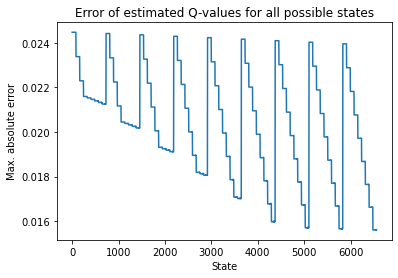


 

 Parameters are : lr = 0.01, window = 2, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  3645


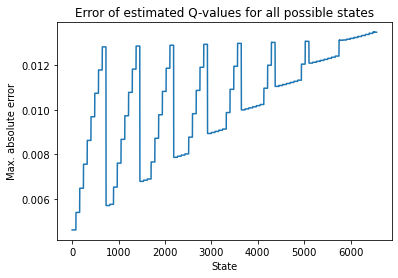


 

 Parameters are : lr = 0.001, window = 2, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  3645


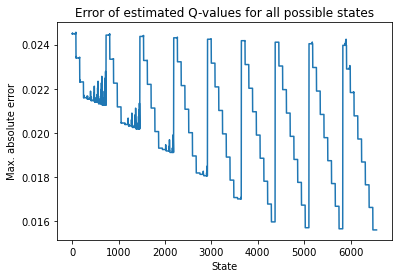


 

 Parameters are : lr = 0.001, window = 2, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  1954


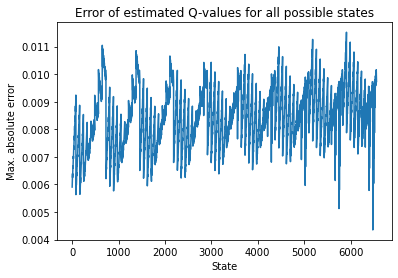


 

 Parameters are : lr = 0.0001, window = 2, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  3645


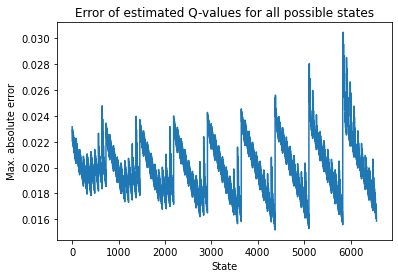


 

 Parameters are : lr = 0.0001, window = 2, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  731


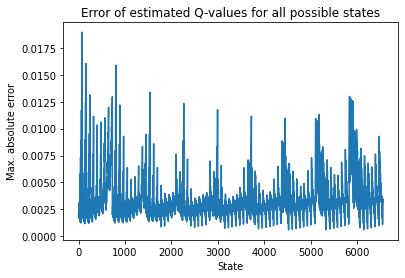

In [39]:
for j in jobs_ar3_w2:
    plot_res_from_multi(j,true_qval_ar3)

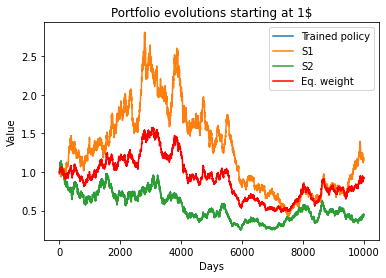

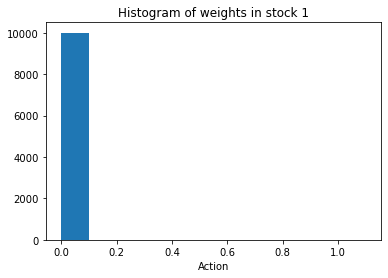

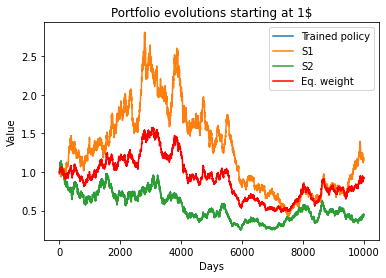

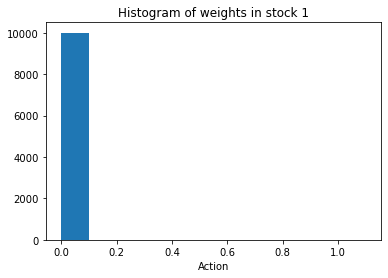

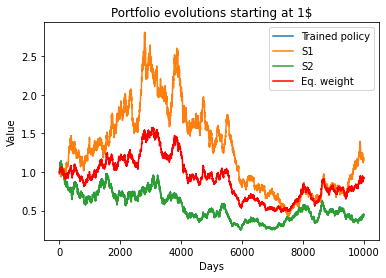

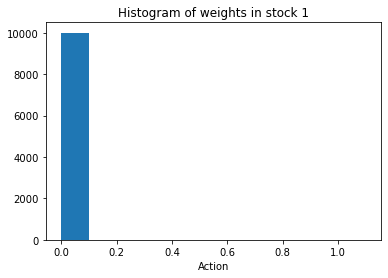

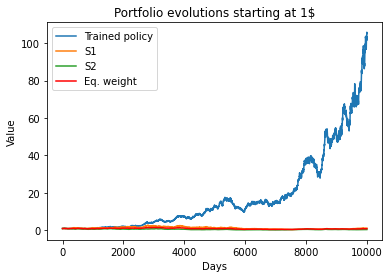

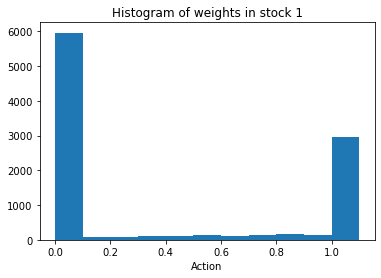

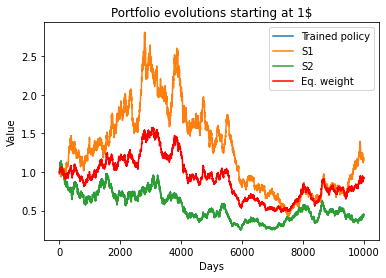

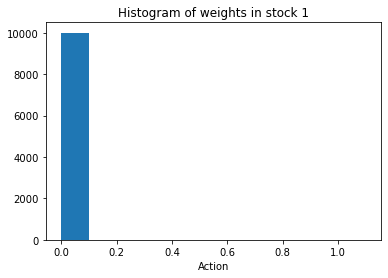

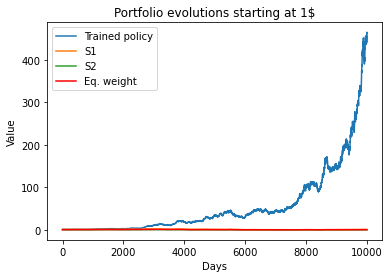

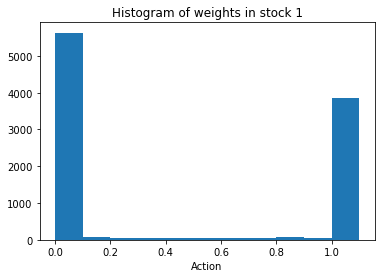

In [40]:
for x in jobs_ar3_w2:
    plot_result(x['exploit_test'])

In [41]:
PROCESSES = 6
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for lr in [1,0.1,0.01]:
        for batch_size in [32,256]:
            params.extend([create_param_DQN(pd.DataFrame(ar_dat),np.array(ar_test), window=2,lr=lr,batch_size=batch_size,nb_epochs=100,true_qval=true_qval_ar3,adaptive_lr=True)])
    
    jobs_ar3_adaptlr_w2 = pool.map(multi_train, params)



 

 Parameters are : lr = 1, window = 2, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  3645


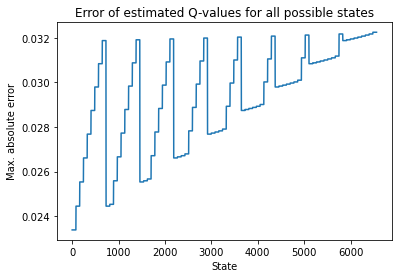


 

 Parameters are : lr = 1, window = 2, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  3645


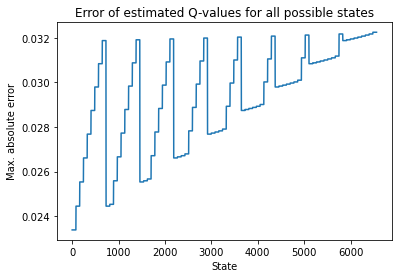


 

 Parameters are : lr = 0.1, window = 2, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  3645


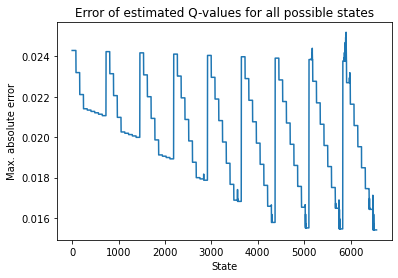


 

 Parameters are : lr = 0.1, window = 2, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  3645


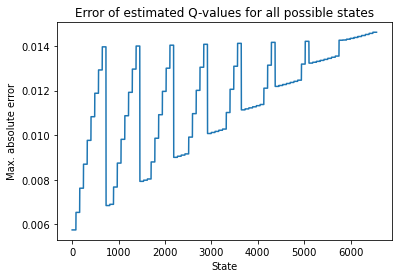


 

 Parameters are : lr = 0.01, window = 2, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  3226


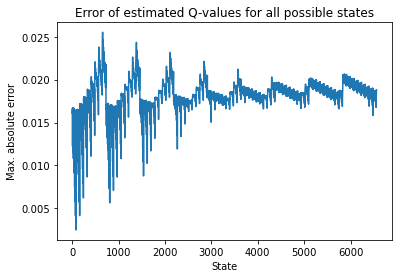


 

 Parameters are : lr = 0.01, window = 2, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  3197


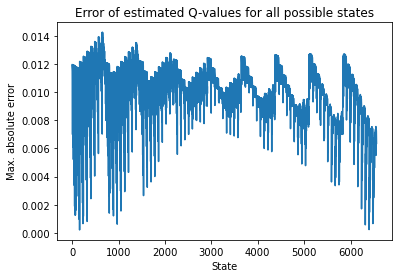

In [42]:
for j in jobs_ar3_adaptlr_w2:
    plot_res_from_multi(j,true_qval_ar3)

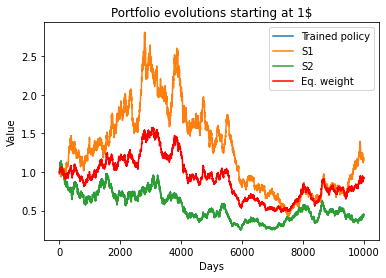

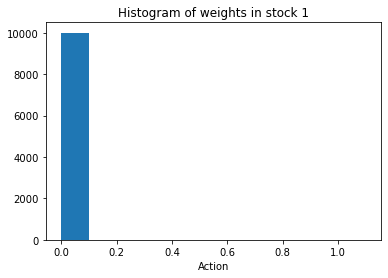

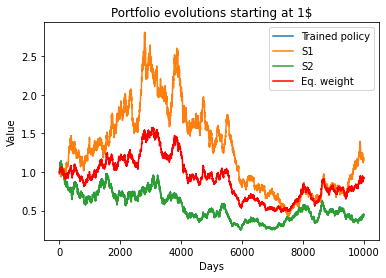

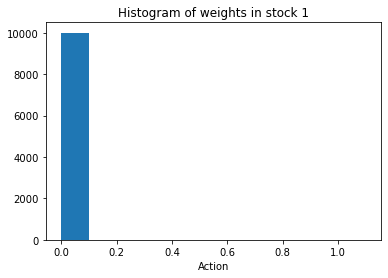

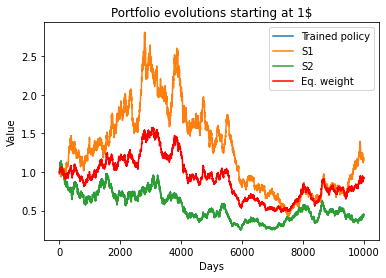

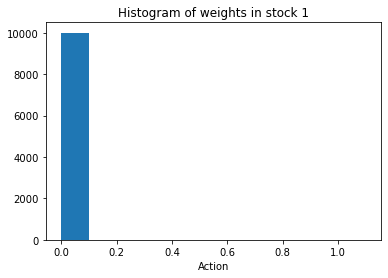

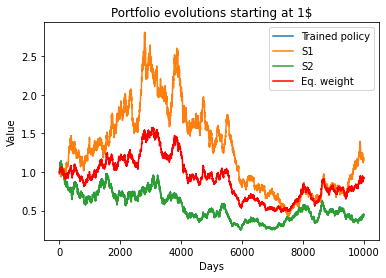

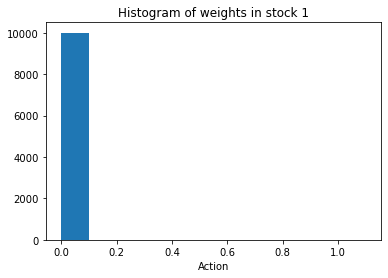

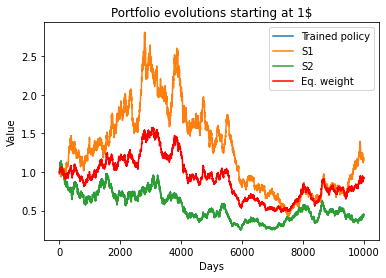

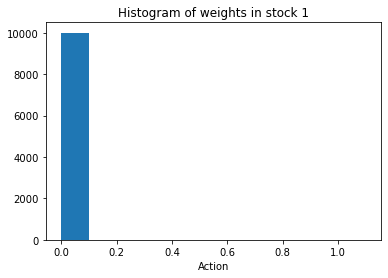

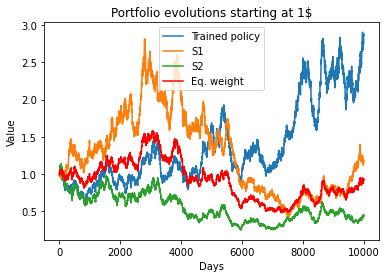

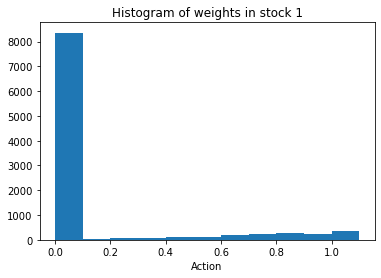

In [43]:
for x in jobs_ar3_adaptlr_w2:
    plot_result(x['exploit_test'])

In [44]:
class DQN2:
    def __init__(self, train_data, window=1, nb_asset=2, nb_action=11, gamma=0.98, batch_size=32, lr=0.1, units1=64,
                 units2=64, last_activation='relu', nb_epochs=1,adaptive_lr=False,tau=1):
        self.window = window
        self.lr = lr
        self.batch_size = batch_size
        self.last_activation = last_activation
        self.units1 = units1
        self.units2 = units2
        self.nb_epochs = nb_epochs
        self.nb_asset = train_data.shape[0]
        self.nb_action = nb_action
        self.model = self.build_model()
        self.model.summary()
        self.train_data = train_data
        self.gamma = gamma
        self.target_model = self.build_model()
        self.update_target_model()
        self.adaptive_lr=adaptive_lr
        self.tau = tau
        self.epsilon = 0.1
        self.optimizer = tf.keras.optimizers.Adam(self.lr)
        
        print('One state at the time')

    def build_model(self):
        inp = tf.keras.layers.Input(shape=(self.nb_asset * self.window,), name="Prev_ret")
        lay = tf.keras.layers.Dense(units=self.units1, activation='relu', name='Dense_1')(inp)
        lay = tf.keras.layers.Dense(units=self.units2, activation='relu', name='Dense_2')(lay)
        q_val = tf.keras.layers.Dense(units=self.nb_action, activation=self.last_activation, name='linear',
                                      kernel_initializer=keras.initializers.Ones(),
                                      bias_initializer=keras.initializers.Zeros())(lay)

        model = tf.keras.models.Model(inp, q_val)
        
        return model

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def chooseW(self, state):
        q_val = self.model.predict(state,verbose=0)[0]
        print(q_val)
        w = np.argmax(q_val) / (self.nb_action - 1)
        return w

    def train(self):

        if self.window == 2:
            nb_episode = int(np.floor(self.train_data.shape[1]) / (1 + self.batch_size))
        else:
            nb_episode = int(np.floor(self.train_data.shape[1]) / self.batch_size)

        print('NB. episodes : ', nb_episode)

        for e in range(nb_episode - 1):
                
            if self.window == 2:
                update_input = self.get_state(np.array(
                    self.train_data.iloc[:, e * (1 + self.batch_size):(e + 1) * (1 + self.batch_size)])).transpose()
                update_nextstate = self.get_state(np.array(self.train_data.iloc[:,
                                                           e * (1 + self.batch_size) + 1:(e + 1) * (
                                                                       1 + self.batch_size) + 1])).transpose()
            else:
                update_input = self.get_state(
                    np.array(self.train_data.iloc[:, e * self.batch_size:(e + 1) * self.batch_size])).transpose()
                update_nextstate = self.get_state(np.array(
                    self.train_data.iloc[:, e * self.batch_size + 1:(e + 1) * self.batch_size + 1])).transpose()

            
            # q_val_next = self.model.predict(update_nextstate,verbose=0)
            for i in range(self.batch_size):
                
                with tf.GradientTape() as tape: 

                    q_values = self.model(update_input[i,:])

                    q_val_next = self.target_model(update_nextstate[i,:])

                    sample_epsilon = np.random.rand()
                    if sample_epsilon <= self.epsilon: # Select random action
                        a = np.random.choice(self.nb_action)
                    else: # Select action with highest Q-value
                        a = np.argmax(q_val[i,:])
                        
                    q_val=q_values[0,a]
                    
                    next_q_values = tf.stop_gradient(self.target_model(update_nextstate[i,:])) # No gradient computation
                    next_action = np.argmax(next_q_values[0])
                    next_q_value = next_q_values[0, next_action]
                    
                    rew_temp = np.dot(np.array([[a / (self.nb_action - 1)], [1 - a / (self.nb_action - 1)]]).transpose(),
                           update_nextstate[i, (self.window - 1) * self.nb_asset:])[0]
                    observed_qval = np.log(rew_temp) + self.gamma * next_qval

                    loss_value = (observed_qval - q_val)**2
                    
                    grads = tape.gradient(loss_value,self.model.trainable_variables)
                    self.optimizer.apply_gradients(zip(grads,self.model.trainable_variables))
                    


            if self.adaptive_lr:
                keras.backend.set_value(self.model.optimizer.learning_rate, self.lr/(1+e)**self.tau)

            self.update_target_model()

    def exploit(self, test_data, test=True, init_inv=100):
        w = np.zeros((2, test_data.shape[1] - self.window))
        w[0, :] = np.argmax(self.model.predict(self.get_state(np.array(test_data.iloc[:, :-1])).transpose(),verbose=0),
                            axis=1) / (self.nb_action - 1)
        w[1, :] = 1 - w[0, :]

        # ret = np.sum(w * test_data.iloc[:, 1:])
        # plt.plot(np.cumprod(ret))
        # plt.plot(np.cumprod(test_data.iloc[0,:]))
        # plt.plot(np.cumprod(test_data.iloc[1,:]))
        # plt.legend(['Trained policy','S1','S2'])
        # plt.show()

        return w

    def compare_DQN2_discrete(self, true_qval, plot = True,print_wrong_action=False):
        states = np.zeros((self.nb_asset * self.window, len(true_qval.keys())))
        for i in range(len(true_qval.keys())):
            states[:, i] = np.array(json.loads(list(true_qval.keys())[i]))

        if self.window == 2:
            temp = copy.deepcopy(states)
            states[1, :] = temp[2, :]
            states[2, :] = temp[1, :]

        pred = self.model.predict(states.transpose(),verbose=0)

        estimated_qval = dict()
        for i in range(len(true_qval.keys())):
            estimated_qval[list(true_qval.keys())[i]] = pred[i, :]

        no_wrong_action= True
        string_param=' Parameters are : lr = '+str(self.lr) + ', window = '+str(self.window)+', batch size = '+ str(self.batch_size)+', nb. epochs = '+str(self.nb_epochs)
        if self.units1 !=64:
            string_param += ', units1 = '+str(self.units1)
        if self.units2 !=64:
            string_param += ', units1 = '+str(self.units2)

        if self.last_activation!='relu':
            string_param += ', last activ. = '+self.last_activation

        if plot:
            print(string_param,flush=True)
            print('\n','Wrong actions : ',flush=True)
            nb_wrong_action=0
            for k in true_qval.keys():
                if np.argmax(true_qval[k]) != np.argmax(estimated_qval[k]):
                    nb_wrong_action+=1

            if nb_wrong_action ==0:
                print('Optimal policy derived !!', flush=True)
            elif nb_wrong_action <=10:
                for k in true_qval.keys():
                    if np.argmax(true_qval[k]) != np.argmax(estimated_qval[k]):
                        print(k, '; Action from discrete policy : ', np.argmax(true_qval[k]), '; Action from DQN2 algorithm : ',np.argmax(estimated_qval[k]),flush=True)
            elif print_wrong_action:
                for k in true_qval.keys():
                    if np.argmax(true_qval[k]) != np.argmax(estimated_qval[k]):
                        print(k, '; Action from discrete policy : ', np.argmax(true_qval[k]),
                              '; Action from DQN2 algorithm : ', np.argmax(estimated_qval[k]), flush=True)

        # print(estimated_qval)

        return [conv_qtables(true_qval, estimated_qval),estimated_qval, string_param]

    def get_state(self, data):
        state = copy.deepcopy(data)

        if self.window == 2:
            state = np.vstack((state[:, :-1], state[:, 1:]))

        return state



In [45]:
PROCESSES = 6
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for lr in [0.01,0.001,0.0001]:
        for batch_size in [32,256]:
                params.extend([create_param_DQN(pd.DataFrame(ar_dat),np.array(ar_test), window=1,lr=lr,batch_size=batch_size,nb_epochs=100,true_qval=true_qval_ar3)])
    
    jobs_ar3 = pool.map(multi_train, params)



 

 Parameters are : lr = 0.01, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


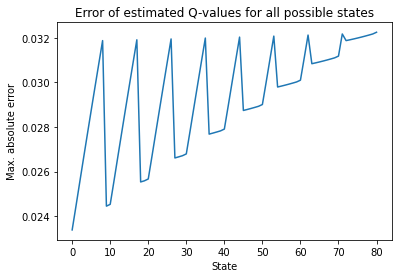


 

 Parameters are : lr = 0.01, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


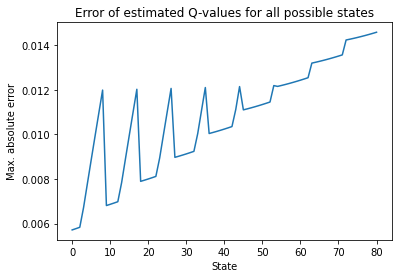


 

 Parameters are : lr = 0.001, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


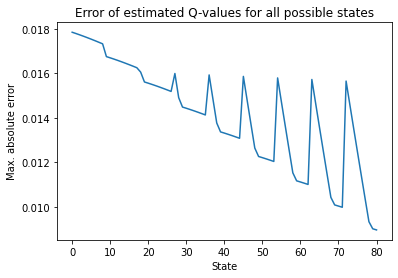


 

 Parameters are : lr = 0.001, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


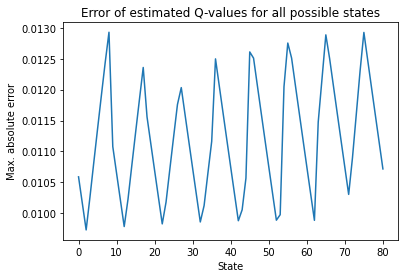


 

 Parameters are : lr = 0.0001, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


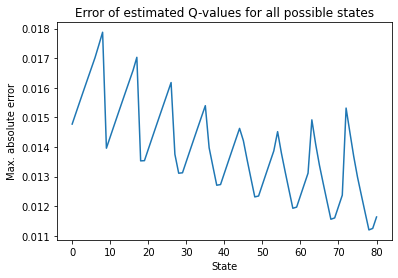


 

 Parameters are : lr = 0.0001, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  24


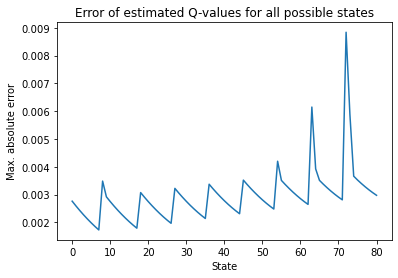

In [46]:
for j in jobs_ar3:
    plot_res_from_multi(j,true_qval_ar3)

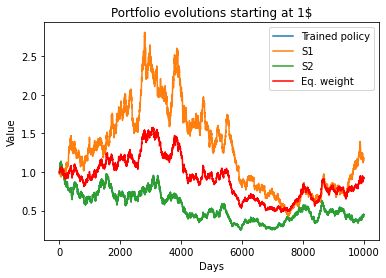

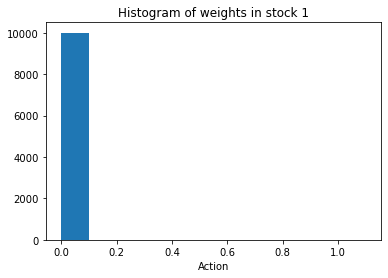

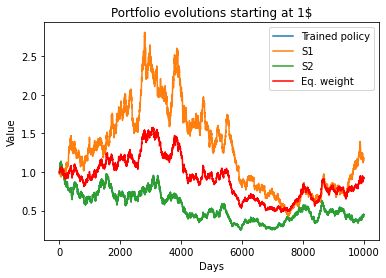

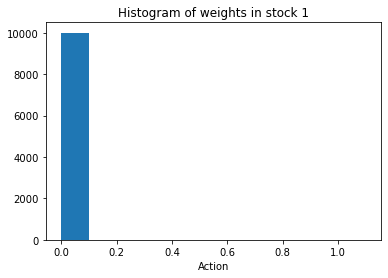

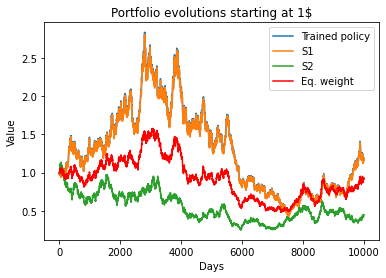

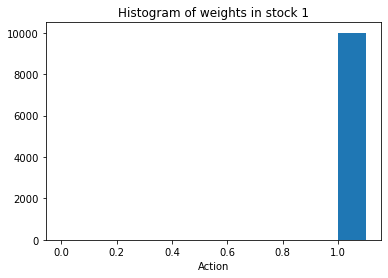

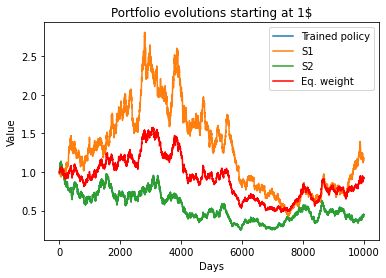

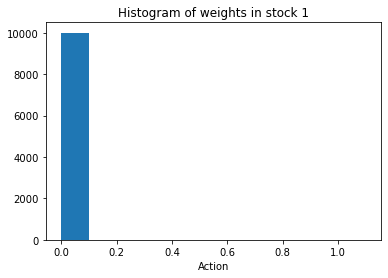

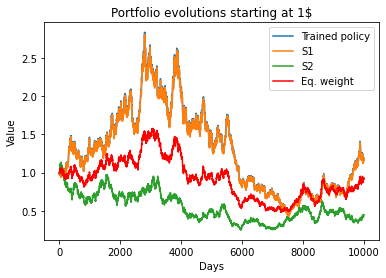

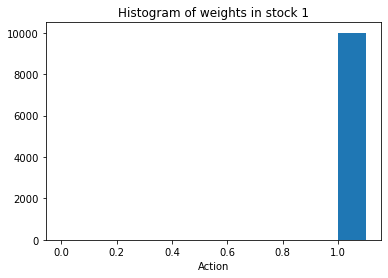

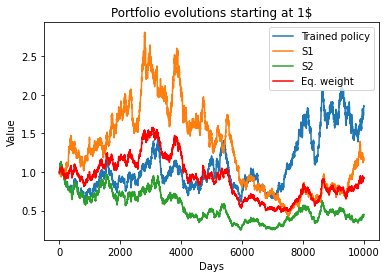

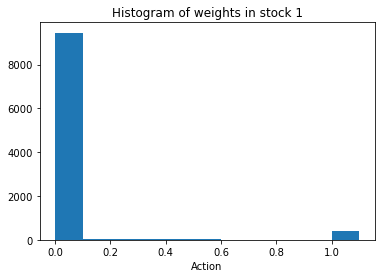

In [47]:
for x in jobs_ar3:
    plot_result(x['exploit_test'])

In [29]:
PROCESSES = 6
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for lr in [1,0.1,0.01]:
        for batch_size in [32,256]:
            params.extend([create_param_DQN(pd.DataFrame(ar_dat),np.array(ar_test), window=1,lr=lr,batch_size=batch_size,nb_epochs=100,true_qval=true_qval_ar3,adaptive_lr=True)])
    
    jobs_ar3_adaptlr = pool.map(multi_train, params)



 

 Parameters are : lr = 1, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


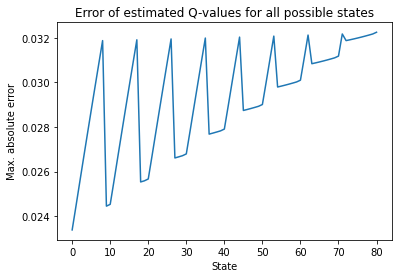


 

 Parameters are : lr = 1, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


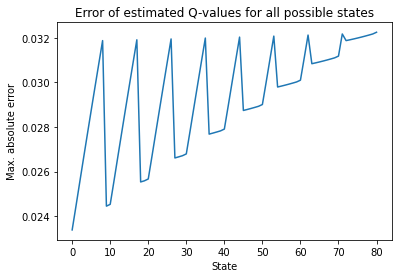


 

 Parameters are : lr = 0.1, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  25


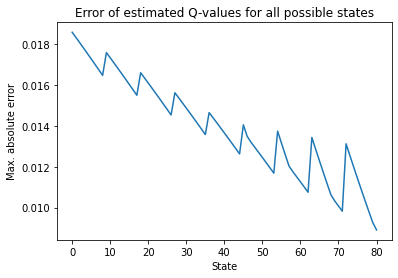


 

 Parameters are : lr = 0.1, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


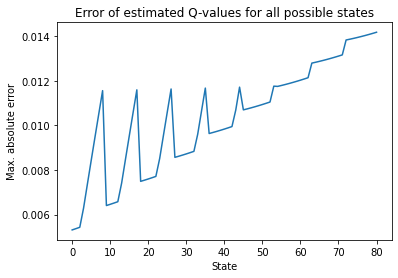


 

 Parameters are : lr = 0.01, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


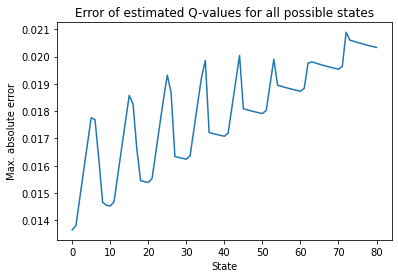


 

 Parameters are : lr = 0.01, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


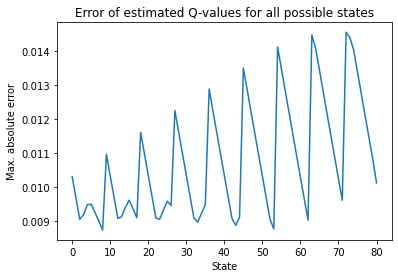

In [48]:
for j in jobs_ar3_adaptlr:
    plot_res_from_multi(j,true_qval_ar3)

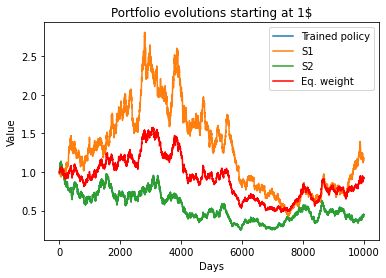

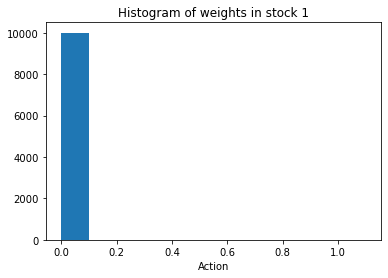

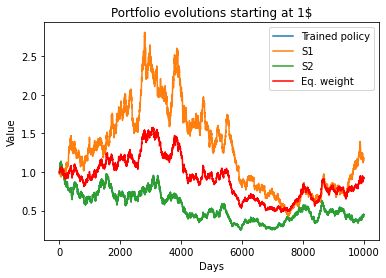

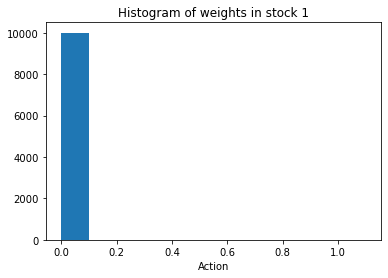

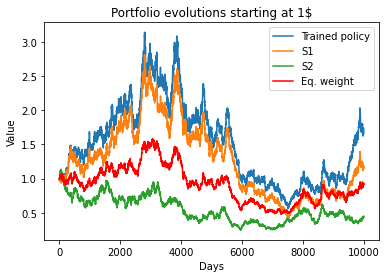

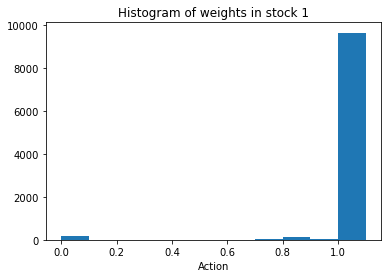

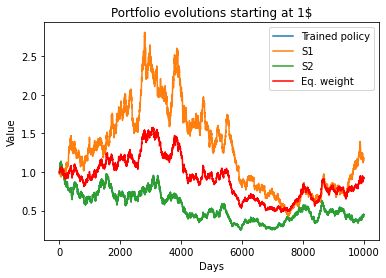

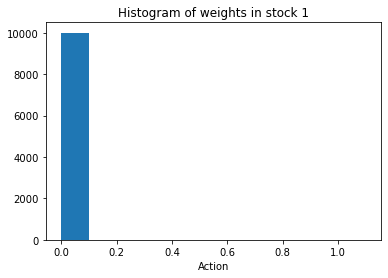

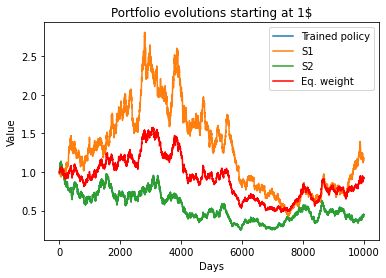

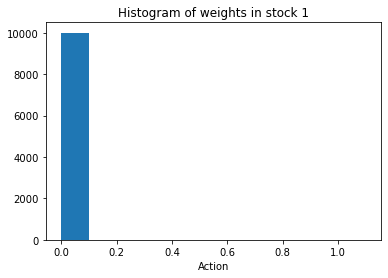

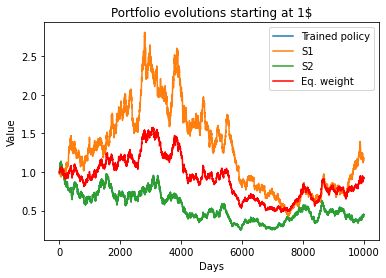

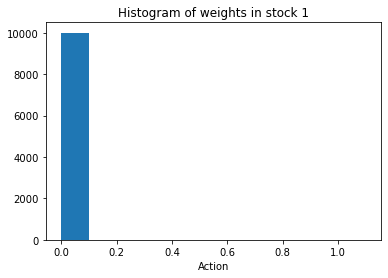

In [49]:
for x in jobs_ar3_adaptlr:
    plot_result(x['exploit_test'])

In [50]:
PROCESSES = 6
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for lr in [0.001,0.0001]:
        for batch_size in [32,54,256]:
            params.extend([create_param_DQN(pd.DataFrame(ar_dat),np.array(ar_test), window=1,lr=lr,batch_size=batch_size,nb_epochs=100,true_qval=true_qval_ar3,adaptive_lr=True)])
    
    jobs_ar3_adaptlr_smaller = pool.map(multi_train, params)



 

 Parameters are : lr = 0.001, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


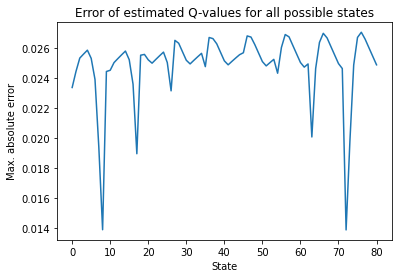


 

 Parameters are : lr = 0.001, window = 1, batch size = 54, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  27


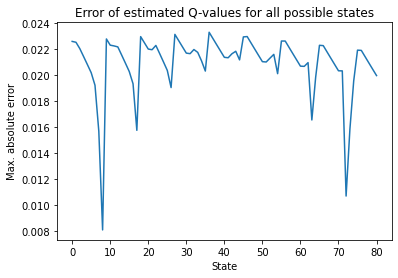


 

 Parameters are : lr = 0.001, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


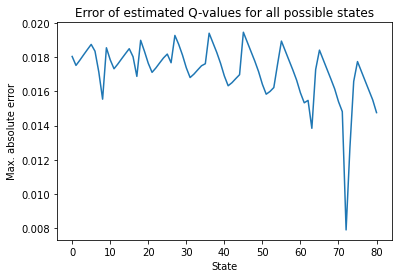


 

 Parameters are : lr = 0.0001, window = 1, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


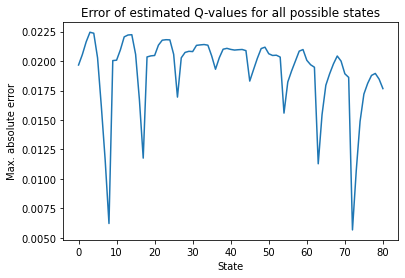


 

 Parameters are : lr = 0.0001, window = 1, batch size = 54, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


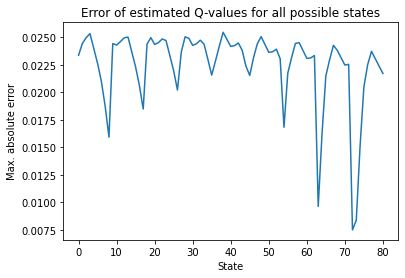


 

 Parameters are : lr = 0.0001, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


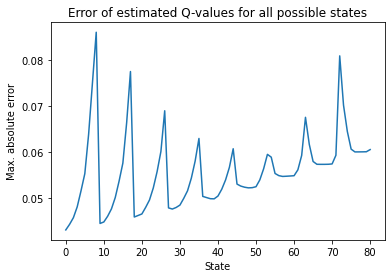

In [51]:
for j in jobs_ar3_adaptlr_smaller:
    plot_res_from_multi(j,true_qval_ar3)

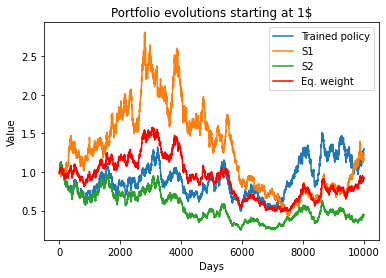

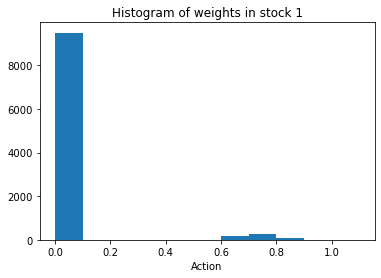

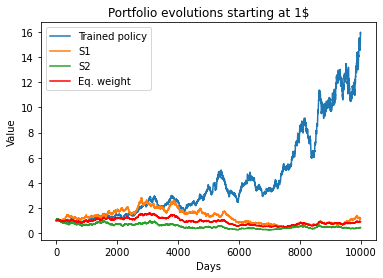

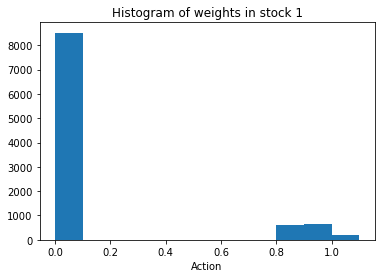

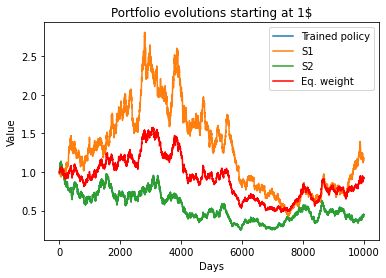

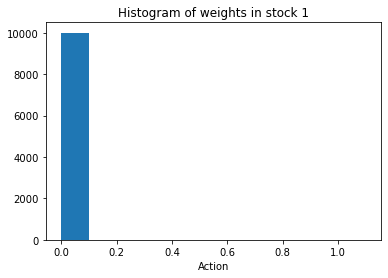

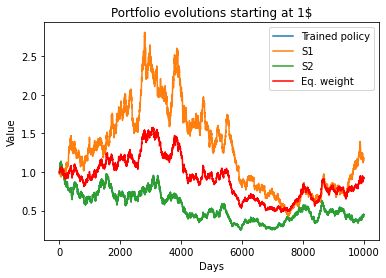

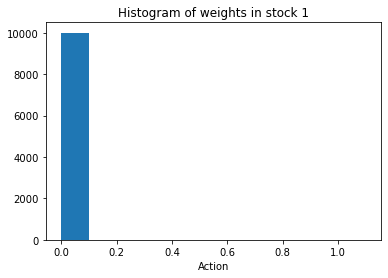

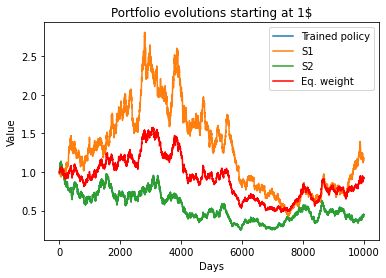

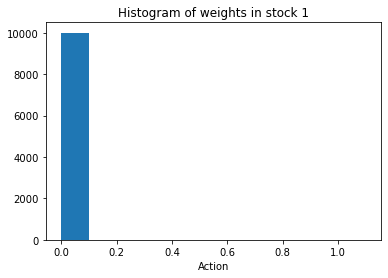

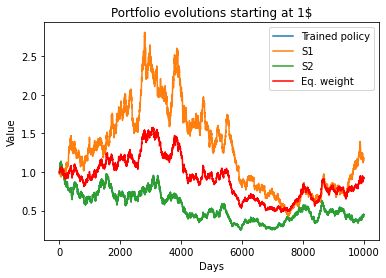

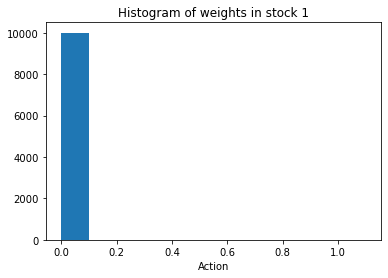

In [52]:
for x in jobs_ar3_adaptlr_smaller:
    plot_result(x['exploit_test'])

In [53]:
PROCESSES = 6
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for lr in [0.00001,0.000001]:
        for batch_size in [64,128,256]:
                params.extend([create_param_DQN(pd.DataFrame(ar_dat),np.array(ar_test), window=1,lr=lr,batch_size=batch_size,nb_epochs=100,true_qval=true_qval_ar3)])
    
    jobs_ar3_smaller = pool.map(multi_train, params)



 

 Parameters are : lr = 1e-05, window = 1, batch size = 64, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  13


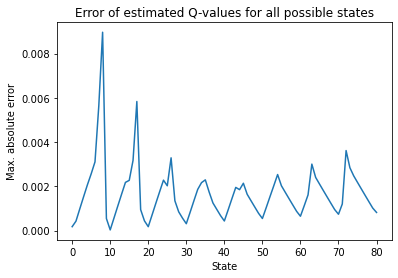


 

 Parameters are : lr = 1e-05, window = 1, batch size = 128, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  81


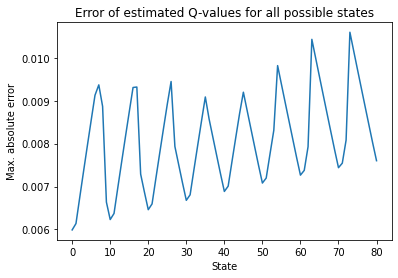


 

 Parameters are : lr = 1e-05, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


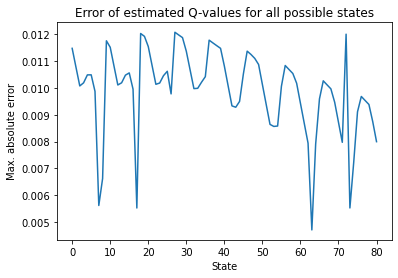


 

 Parameters are : lr = 1e-06, window = 1, batch size = 64, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


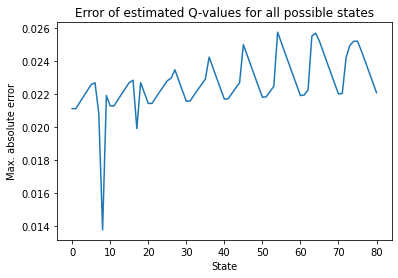


 

 Parameters are : lr = 1e-06, window = 1, batch size = 128, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


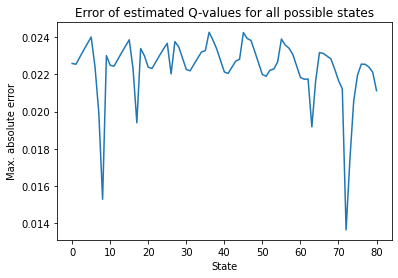


 

 Parameters are : lr = 1e-06, window = 1, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  45


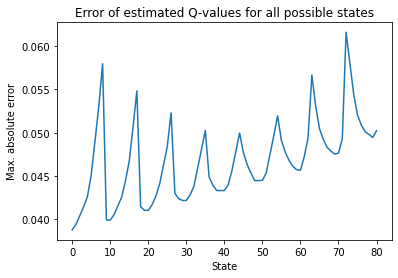

In [54]:
for j in jobs_ar3_smaller:
    plot_res_from_multi(j,true_qval_ar3)

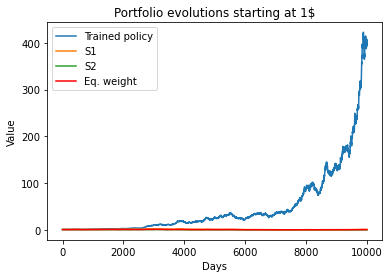

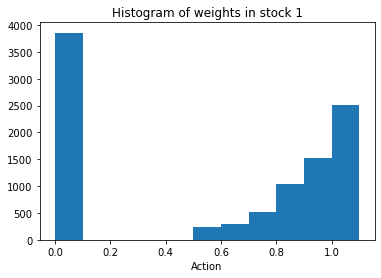

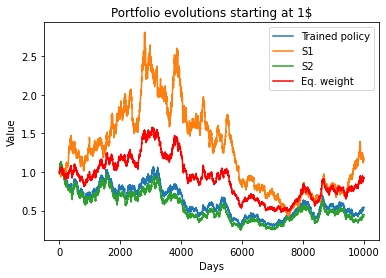

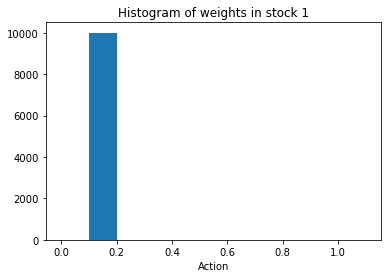

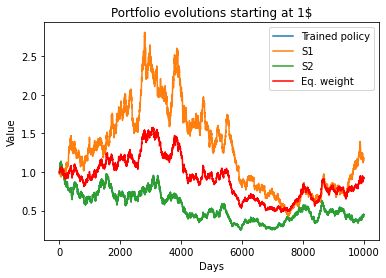

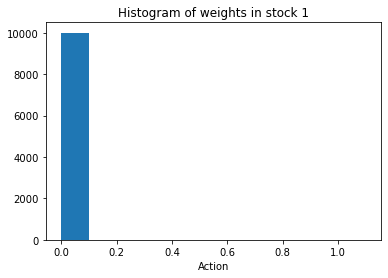

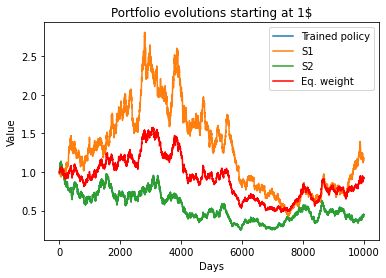

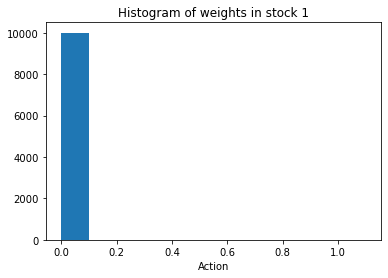

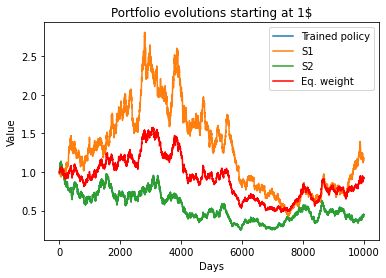

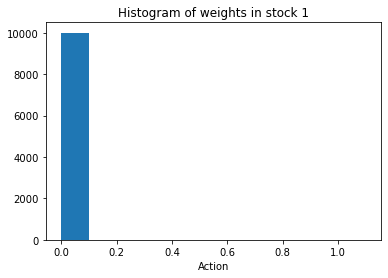

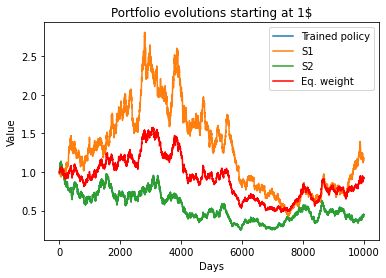

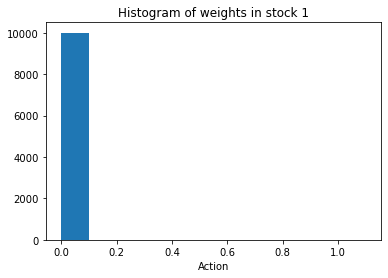

In [55]:
for x in jobs_ar3_smaller:
    plot_result(x['exploit_test'])

In [56]:
PROCESSES = 6
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for lr in [0.01,0.001,0.0001]:
        for batch_size in [32,256]:
                params.extend([create_param_DQN(pd.DataFrame(ar_dat),np.array(ar_test), window=2,lr=lr,batch_size=batch_size,nb_epochs=100,true_qval=true_qval_ar3)])
    
    jobs_ar3_w2 = pool.map(multi_train, params)



 

 Parameters are : lr = 0.01, window = 2, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  3645


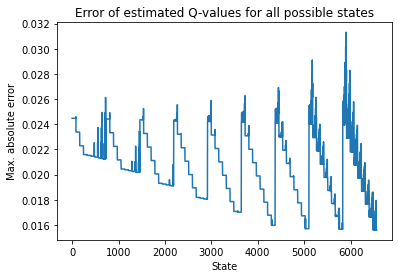


 

 Parameters are : lr = 0.01, window = 2, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  3645


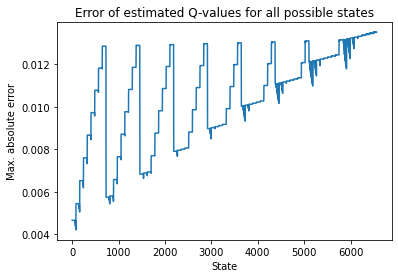


 

 Parameters are : lr = 0.001, window = 2, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  3645


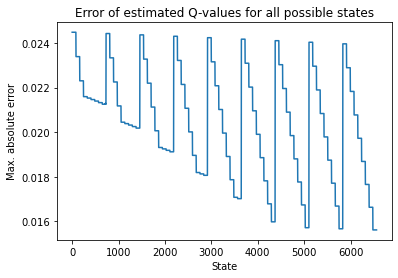


 

 Parameters are : lr = 0.001, window = 2, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  2665


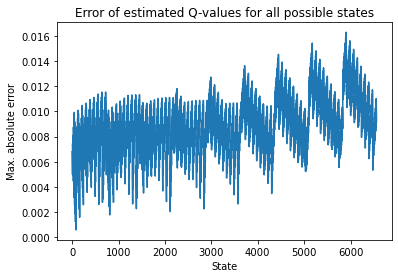


 

 Parameters are : lr = 0.0001, window = 2, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  3645


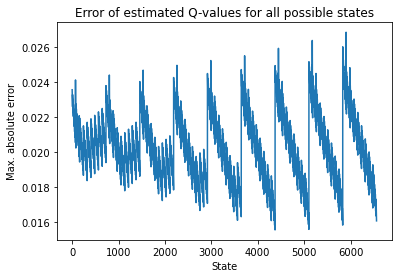


 

 Parameters are : lr = 0.0001, window = 2, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  3662


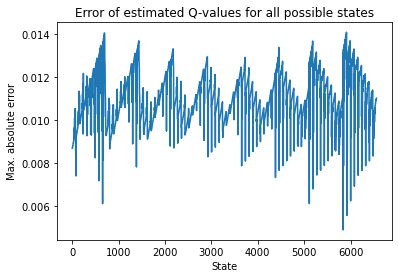

In [57]:
for j in jobs_ar3_w2:
    plot_res_from_multi(j,true_qval_ar3)

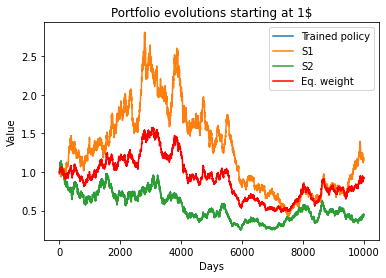

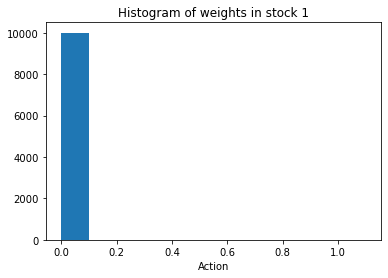

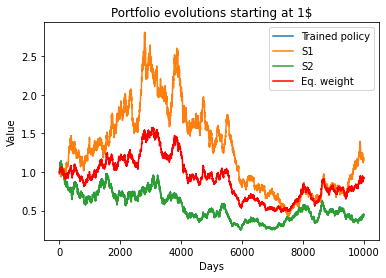

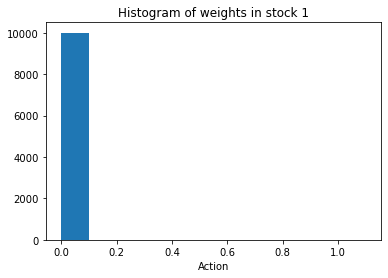

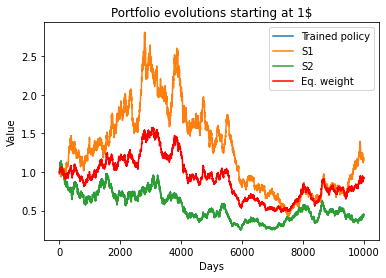

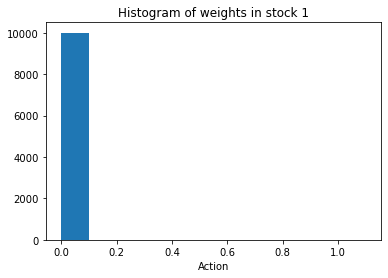

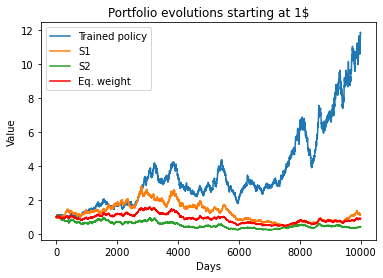

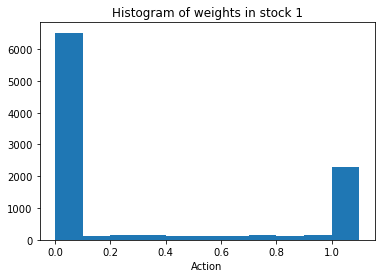

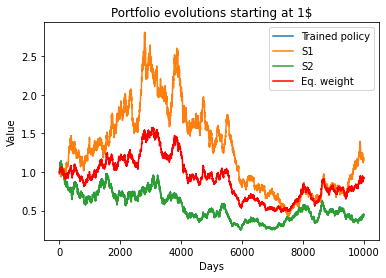

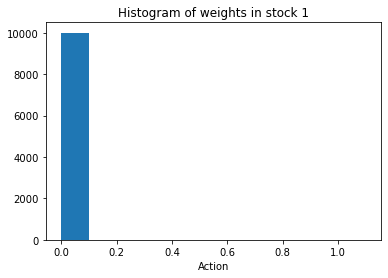

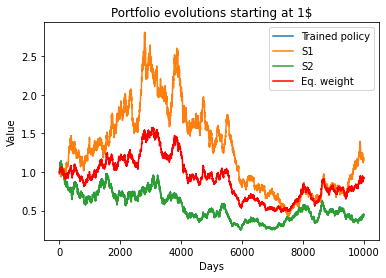

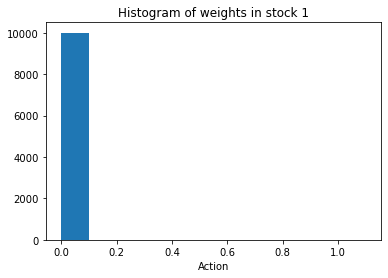

In [58]:
for x in jobs_ar3_w2:
    plot_result(x['exploit_test'])

In [59]:
PROCESSES = 6
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for lr in [1,0.1,0.01]:
        for batch_size in [32,256]:
            params.extend([create_param_DQN(pd.DataFrame(ar_dat),np.array(ar_test), window=2,lr=lr,batch_size=batch_size,nb_epochs=100,true_qval=true_qval_ar3,adaptive_lr=True)])
    
    jobs_ar3_adaptlr_w2 = pool.map(multi_train, params)



 

 Parameters are : lr = 1, window = 2, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  3645


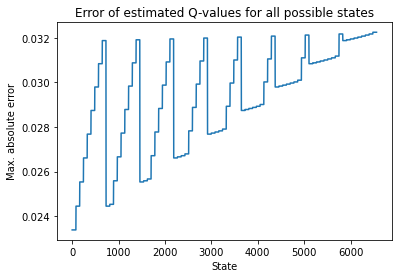


 

 Parameters are : lr = 1, window = 2, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  3645


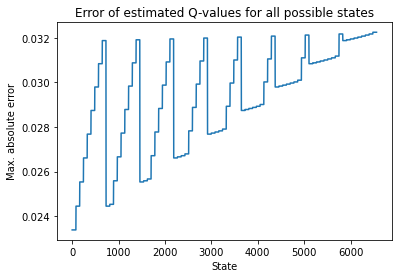


 

 Parameters are : lr = 0.1, window = 2, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  3645


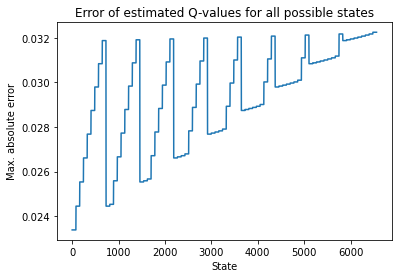


 

 Parameters are : lr = 0.1, window = 2, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  3645


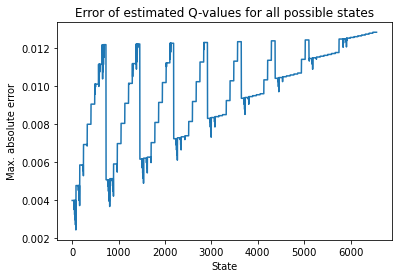


 

 Parameters are : lr = 0.01, window = 2, batch size = 32, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  1334


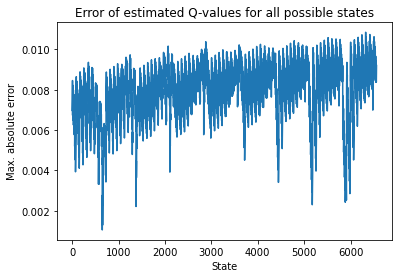


 

 Parameters are : lr = 0.01, window = 2, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  2644


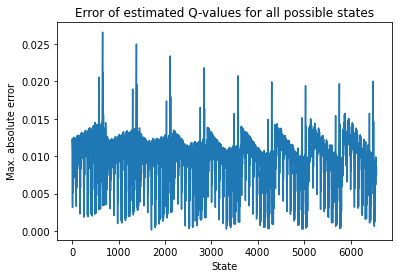

In [60]:
for j in jobs_ar3_adaptlr_w2:
    plot_res_from_multi(j,true_qval_ar3)

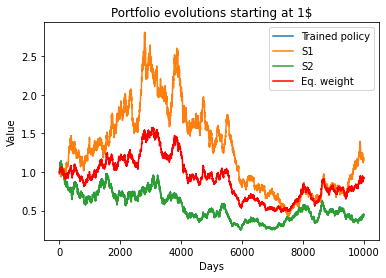

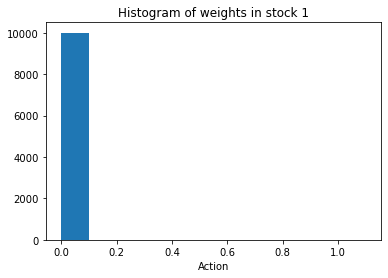

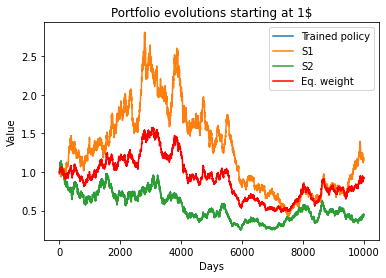

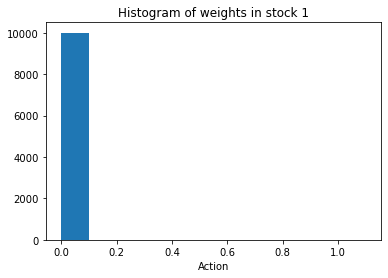

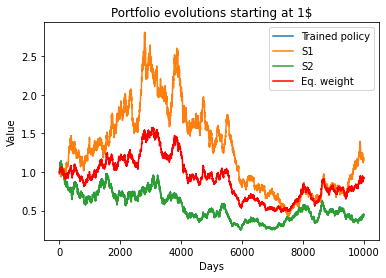

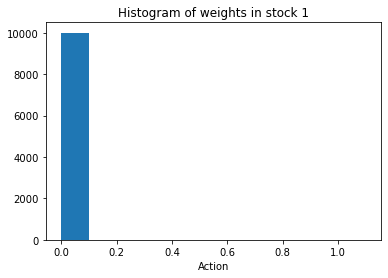

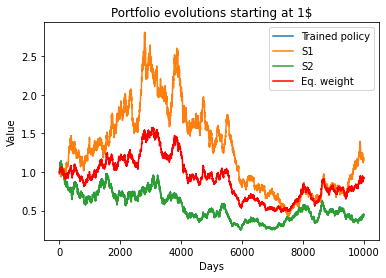

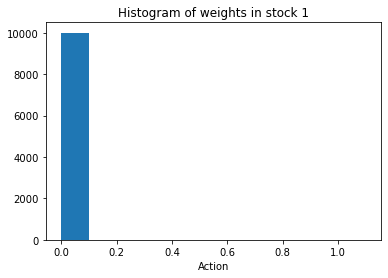

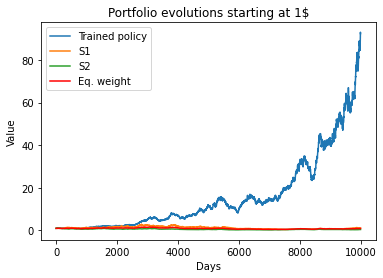

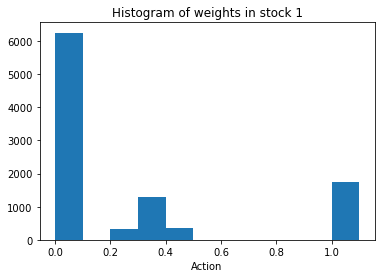

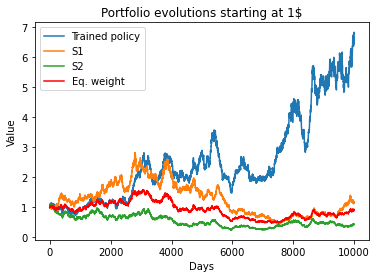

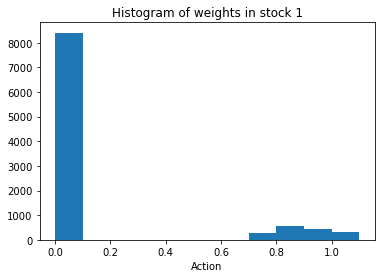

In [61]:
for x in jobs_ar3_adaptlr_w2:
    plot_result(x['exploit_test'])

In [64]:
PROCESSES = 4
with multiprocessing.Pool(PROCESSES) as pool:
    params=list()
    for lr in [0.001]:
        for batch_size in [64,256]:
            for tau in [1,0.4]:
                params.extend([create_param_DQN(pd.DataFrame(ar_dat),np.array(ar_test), window=2,lr=lr,batch_size=batch_size,nb_epochs=100,tau=tau,true_qval=true_qval_ar3,adaptive_lr=True)])
    
    jobs_ar3_adaptlr_w2 = pool.map(multi_train, params)



 

 Parameters are : lr = 0.001, window = 2, batch size = 64, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  3542


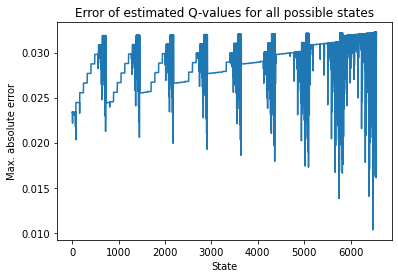


 

 Parameters are : lr = 0.001, window = 2, batch size = 64, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  856


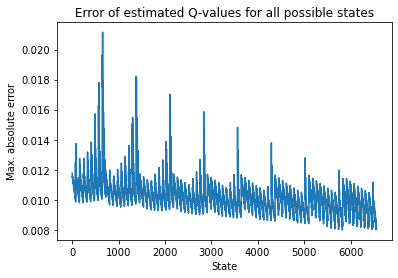


 

 Parameters are : lr = 0.001, window = 2, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  3645


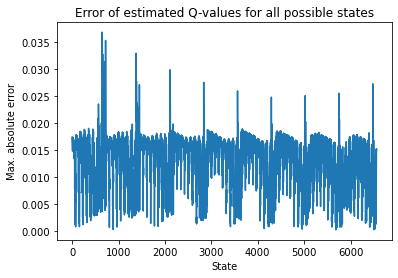


 

 Parameters are : lr = 0.001, window = 2, batch size = 256, nb. epochs = 100

 Wrong actions : 
There are a lot of wrong actions :  4027


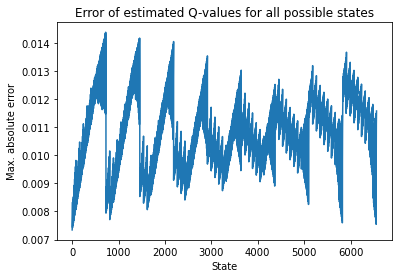

In [65]:
for j in jobs_ar3_adaptlr_w2:
    plot_res_from_multi(j,true_qval_ar3)

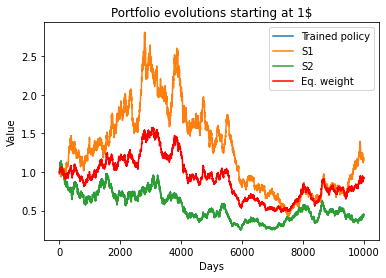

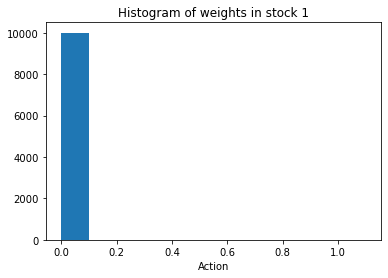

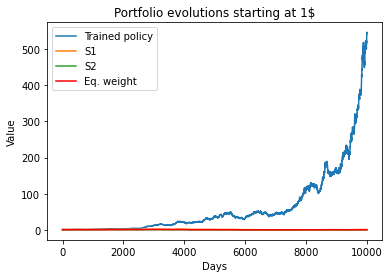

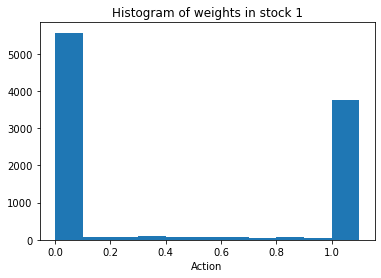

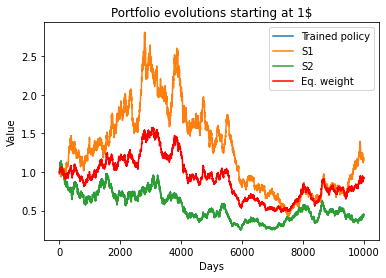

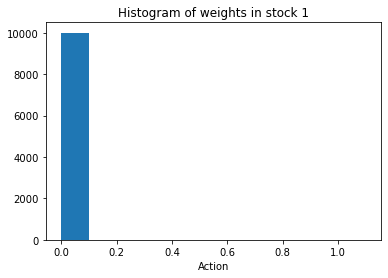

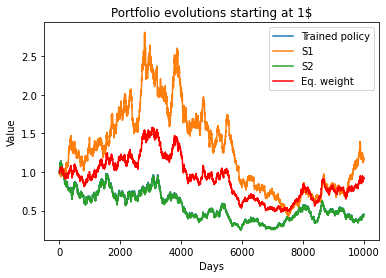

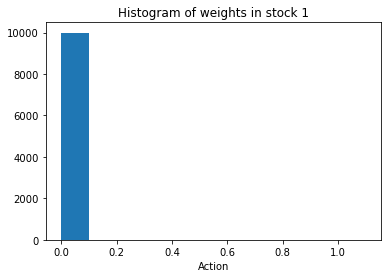

In [66]:
for x in jobs_ar3_adaptlr_w2:
    plot_result(x['exploit_test'])